# Production Prediction | An Analysis for an Oil Trading Company


# Problem Description

Our client is engaged in the trading of land rights for oil and gas extraction. Traditionally, they have relied on manually constructed type curves to forecast production, a method that has proven to be less accurate and has presented opportunities for improvement. Our objective is to develop a robust model that accurately identifies wells with the highest potential, thereby prioritizing investments and enhancing the company's earnings.

## Understanding

In our analysis, we develop a machine learning model that performs a twofold function. Initially, it categorizes wells based on various attributes, including geographic location, depth, age, and geological characteristics. These attributes are critical in uncovering the factors that contribute to higher well productivity. For instance, wells situated in specific regions might encounter hydrocarbon deposits more frequently, while older wells might necessitate interventions to sustain their productivity.

By understanding these dynamics, we can pinpoint the primary groups of wells. Following this classification, we apply a time series analysis to forecast expected productivity, taking into account trends, levels, and seasonality. This advanced analytical approach enables us to make data-driven decisions that significantly bolster our client's profitability.

# Assumptions Made

- **Forecast Period**: The analysis is intended to produce forecasts covering a duration of one year.
- **Dataset Representativeness**: The model operates under the assumption that the dataset provides a representative sample of the wells within the targeted state. This assumption allows for the extrapolation of the model's findings to the broader well population. It is important to recognize and address any potential biases arising from incomplete dataset coverage to ensure the validity and reliability of the forecast outcomes.

## Limitations

- **Production History Requirement**: The analysis is confined to wells that have at least 12 months of production data available. 
- **Longevity Data**: Limited data is available for wells with operational spans exceeding 8 years, as only a small portion of wells surpass this duration. Consequently, the model's predictive accuracy for this subset may be diminished.
- **Technological Specificity**: The dataset exclusively encompasses wells employing horizontal drilling technologies. Therefore, the model's applicability and accuracy are restricted to wells of this technological type, with potential inaccuracies arising when applied to wells utilizing alternative extraction methods.
- **Geographic Limitation**: The model utilizes data solely from wells located in New Mexico. Applying the model to predict the productivity of wells in other regions carries inherent risks due to this geographic specificity.

# Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas as gpd
import folium
import requests
import osmnx as ox
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from matplotlib.colors import to_hex, LogNorm
import branca.colormap as cmp
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import csv
from sklearn.linear_model import LinearRegression
import calendar
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="seaborn._oldcore")

## Dataset 1 - Production Data



In [2]:
pd.set_option('display.max_columns',None)
Prod_Data = pd.read_excel("./data/Production Data.xlsx", sheet_name="env_csv-Production-38aa2_2023-1", engine='openpyxl')
Prod_Data = Prod_Data[['API_UWI', 'ProducingMonth', 'TotalProdMonths', 'ProducingDays', 'Prod_BOE', 'Prod_MCFE',
                       'LiquidsProd_BBL', 'GasProd_MCF', 'WaterProd_BBL',
                      'CDProd_BOEPerDAY', 'CDProd_MCFEPerDAY', 'CDLiquids_BBLPerDAY', 'CDGas_MCFPerDAY',
                       'CDWater_BBLPerDAY', 'PDProd_BOEPerDAY', 'PDProd_MCFEPerDAY',
                       'PDLiquids_BBLPerDAY', 'PDGas_MCFPerDAY', 'PDWater_BBLPerDAY']]
Prod_Data.head(3)

,API_UWI,ProducingMonth,TotalProdMonths,ProducingDays,Prod_BOE,Prod_MCFE,LiquidsProd_BBL,GasProd_MCF,WaterProd_BBL,CDProd_BOEPerDAY,CDProd_MCFEPerDAY,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,PDProd_BOEPerDAY,PDProd_MCFEPerDAY,PDLiquids_BBLPerDAY,PDGas_MCFPerDAY,PDWater_BBLPerDAY
0,30-015-43920,2018-03-01,1,31,0,0,0,0,214,0,0,0,0,7,0,0,0,0,7
1,30-015-43920,2018-04-01,2,30,3552,21312,2234,7908,32876,118,710,74,264,1096,118,710,74,264,1096
2,30-015-43920,2018-05-01,3,31,35582,213491,26486,54575,110317,1148,6887,854,1760,3559,1148,6887,854,1760,3559


For the Production Dataset containing historical analysis, we've identified essential variables. Cumulative variables in the dataset were excluded. Additionally, we will introduce new variables to the model using Feature Engineering to account for lags and trends.

In [3]:
Prod_Data = Prod_Data.set_index('API_UWI')
Prod_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106835 entries, 30-015-43920 to 30-025-50859
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ProducingMonth       106835 non-null  datetime64[ns]
 1   TotalProdMonths      106835 non-null  int64         
 2   ProducingDays        106835 non-null  int64         
 3   Prod_BOE             106835 non-null  int64         
 4   Prod_MCFE            106835 non-null  int64         
 5   LiquidsProd_BBL      106835 non-null  int64         
 6   GasProd_MCF          106835 non-null  int64         
 7   WaterProd_BBL        106835 non-null  int64         
 8   CDProd_BOEPerDAY     106835 non-null  int64         
 9   CDProd_MCFEPerDAY    106835 non-null  int64         
 10  CDLiquids_BBLPerDAY  106835 non-null  int64         
 11  CDGas_MCFPerDAY      106835 non-null  int64         
 12  CDWater_BBLPerDAY    106835 non-null  int64         
 13  PD

Variables are in the correct type, no need to treat them. 

In [4]:
Prod_Data.isnull().sum()

ProducingMonth         0
TotalProdMonths        0
ProducingDays          0
Prod_BOE               0
Prod_MCFE              0
LiquidsProd_BBL        0
GasProd_MCF            0
WaterProd_BBL          0
CDProd_BOEPerDAY       0
CDProd_MCFEPerDAY      0
CDLiquids_BBLPerDAY    0
CDGas_MCFPerDAY        0
CDWater_BBLPerDAY      0
PDProd_BOEPerDAY       0
PDProd_MCFEPerDAY      0
PDLiquids_BBLPerDAY    0
PDGas_MCFPerDAY        0
PDWater_BBLPerDAY      0
dtype: int64

No missings in this view. Will check if we have missing months analyzing each of the wells. 

In [5]:
# Sanity Check to understand the Producing Month of each of the wells
Prod_Data_Missing = Prod_Data.groupby(['API_UWI']).agg(
    Cnt_Producing_Month=('ProducingMonth', 'count'),
    CntDt_Producing_Month=('ProducingMonth', 'nunique'),
    Max_TotalProdMonths=('TotalProdMonths', 'max')
).reset_index()

filtered_data = Prod_Data_Missing[
    (Prod_Data_Missing['Cnt_Producing_Month'] != Prod_Data_Missing['CntDt_Producing_Month']) |
    (Prod_Data_Missing['Cnt_Producing_Month'] != Prod_Data_Missing['Max_TotalProdMonths']) |
    (Prod_Data_Missing['CntDt_Producing_Month'] != Prod_Data_Missing['Max_TotalProdMonths'])
]
filtered_data

,API_UWI,Cnt_Producing_Month,CntDt_Producing_Month,Max_TotalProdMonths
70,30-015-43798,58,58,59


Only one well with this characteristics, is easier to filter it than treating it.

In [6]:
# Summary Statistics for the dataset
Prod_Data.drop('30-015-43798', inplace=True)
Prod_Data.describe(include='all')

,ProducingMonth,TotalProdMonths,ProducingDays,Prod_BOE,Prod_MCFE,LiquidsProd_BBL,GasProd_MCF,WaterProd_BBL,CDProd_BOEPerDAY,CDProd_MCFEPerDAY,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,PDProd_BOEPerDAY,PDProd_MCFEPerDAY,PDLiquids_BBLPerDAY,PDGas_MCFPerDAY,PDWater_BBLPerDAY
count,106777,106777.000000,106777.000000,106777.000000,1.067770e+05,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000,106777.000000
mean,2021-07-08 05:32:42.860915968,26.698034,28.443682,13196.661809,7.917948e+04,8793.850633,26416.374397,25251.235097,433.542692,2601.250110,288.914101,867.808976,829.665153,462.917211,2777.494882,308.738455,925.116092,896.883748
min,2009-01-01 00:00:00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2020-07-01 00:00:00,11.000000,29.000000,4138.000000,2.482800e+04,2585.000000,7819.000000,7666.000000,136.000000,817.000000,85.000000,257.000000,252.000000,145.000000,867.000000,90.000000,273.000000,266.000000
50%,2021-12-01 00:00:00,22.000000,30.000000,8190.000000,4.914000e+04,5215.000000,16262.000000,15373.000000,269.000000,1615.000000,171.000000,535.000000,505.000000,283.000000,1699.000000,180.000000,563.000000,531.000000
75%,2022-11-01 00:00:00,39.000000,31.000000,16113.000000,9.667700e+04,10602.000000,33543.000000,31574.000000,529.000000,3175.000000,348.000000,1103.000000,1037.000000,558.000000,3348.000000,368.000000,1159.000000,1101.000000
max,2023-09-01 00:00:00,175.000000,31.000000,187682.000000,1.126090e+06,130987.000000,451789.000000,506241.000000,6054.000000,36325.000000,4292.000000,15060.000000,16875.000000,34179.000000,205074.000000,25237.000000,60580.000000,60762.000000
std,NaN,20.157538,5.719104,15153.983677,9.092389e+04,10629.833254,30844.201183,28771.408233,497.217791,2983.312161,348.789503,1012.111654,944.645748,571.870159,3431.228557,397.092957,1188.775613,1122.364164


From the summary statistics we can observe that:

- The entities in the dataset typically produced nearly every day of the month, with an average of around 28 days of production, indicating consistent and almost full-month operations.

- There's a wide variation in the monthly production volumes, with some very high outliers pushing the maximum value far above the average.

- The data spans over 175 months (14 years) of production, from early 2009 to late 2023, with a distribution that, at this level of detail, suggests steady and ongoing data collection over this period. Further analysis will be developed.

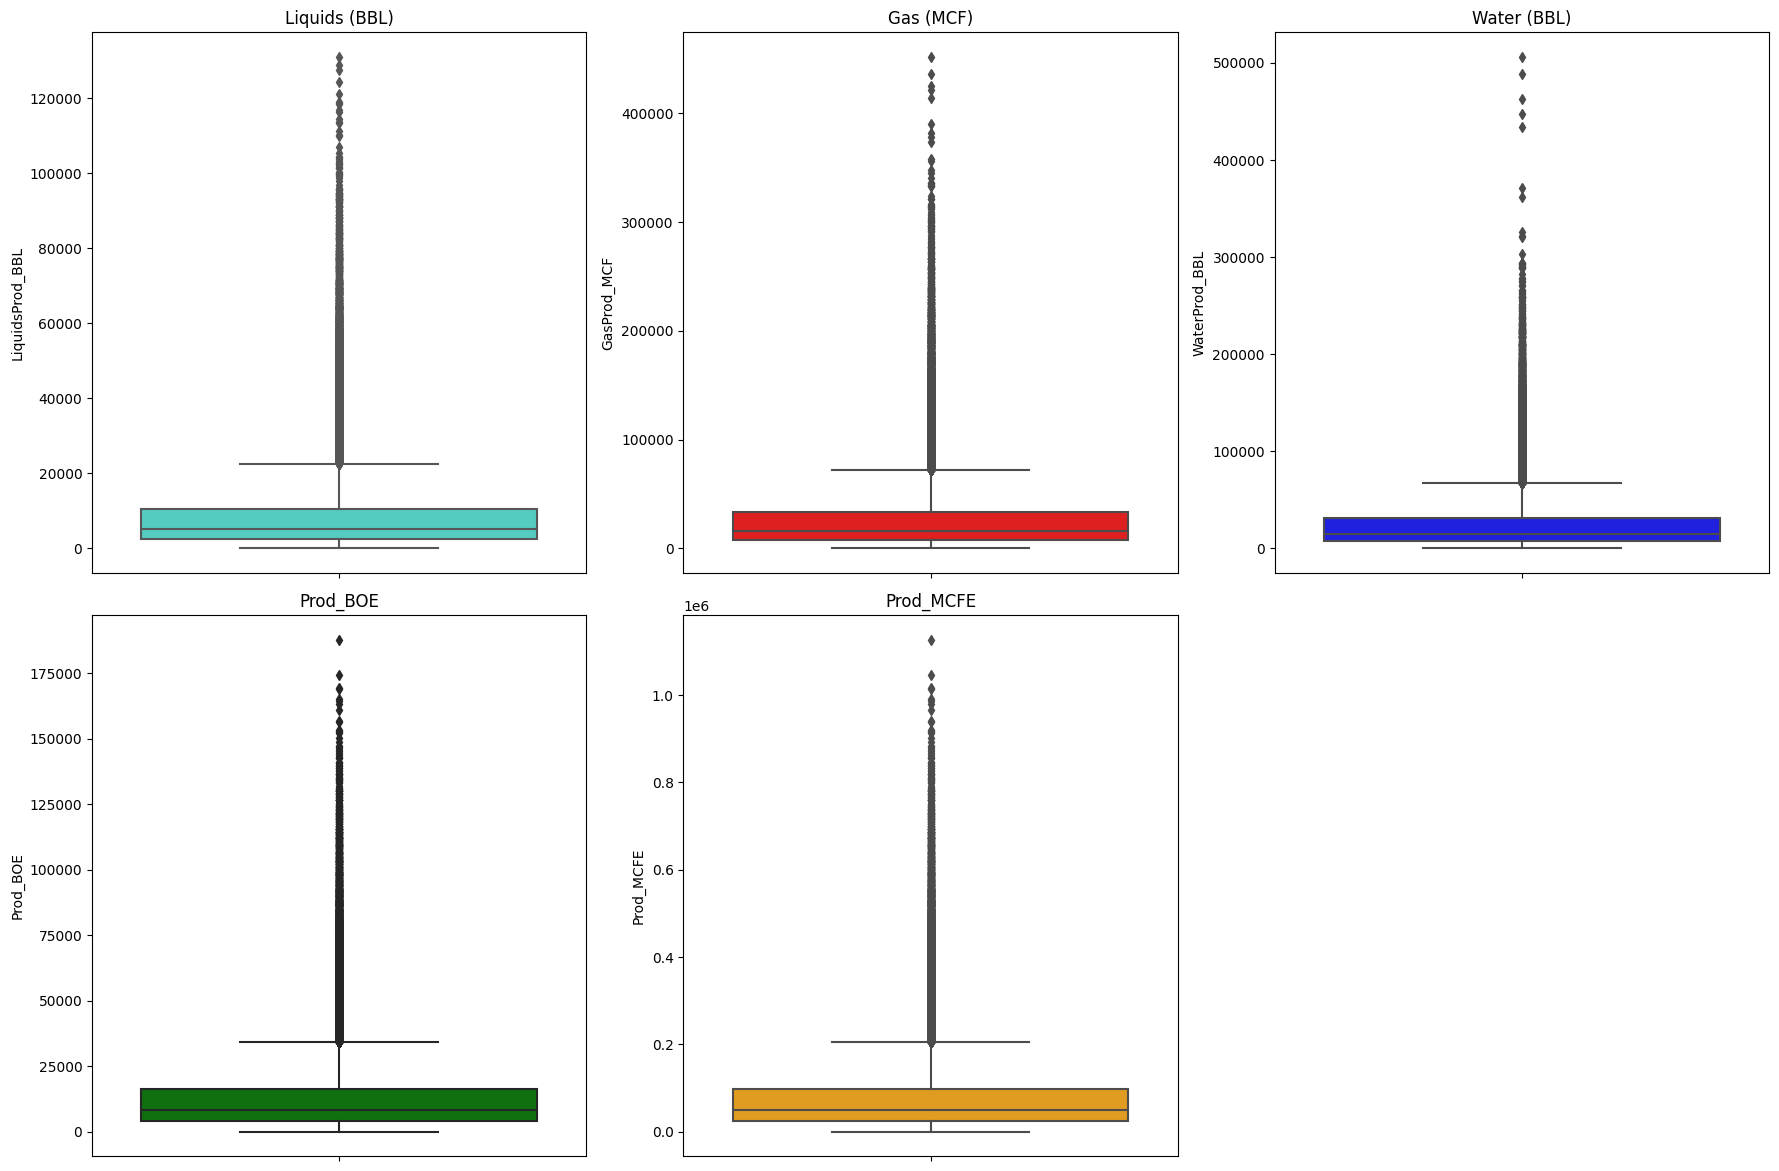

In [7]:
# Boxplots of each production type
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.boxplot(data=Prod_Data, y='LiquidsProd_BBL', ax=axes[0, 0], color='turquoise').set_title('Liquids (BBL)')
sns.boxplot(data=Prod_Data, y='GasProd_MCF', ax=axes[0, 1], color='red').set_title('Gas (MCF)')
sns.boxplot(data=Prod_Data, y='WaterProd_BBL', ax=axes[0, 2], color='blue').set_title('Water (BBL)')
sns.boxplot(data=Prod_Data, y='Prod_BOE', ax=axes[1, 0], color='green').set_title('Prod_BOE')
sns.boxplot(data=Prod_Data, y='Prod_MCFE', ax=axes[1, 1], color='orange').set_title('Prod_MCFE')

plt.tight_layout()
fig.delaxes(axes[1][2])


The variables that we need for the prediction of the productivity of the wells are all skewed, with significant outliers that have to be treated when creating model predictions. We will treat them to avoid biases in the performance of the model. 

In [8]:
# Treat outliers | Apply the 99th percentile capping to all numeric columns
numeric_columns = Prod_Data.select_dtypes(include=[np.number]).columns.difference(['TotalProdMonths', 'ProducingDays'])

# Copy
Prod_Data_Outliers=Prod_Data

for column in numeric_columns:
    p99 = Prod_Data_Outliers[column].quantile(0.99)
    Prod_Data_Outliers[column] = Prod_Data_Outliers[column].apply(lambda x: min(x, p99))

Prod_Data_Outliers.head()

,ProducingMonth,TotalProdMonths,ProducingDays,Prod_BOE,Prod_MCFE,LiquidsProd_BBL,GasProd_MCF,WaterProd_BBL,CDProd_BOEPerDAY,CDProd_MCFEPerDAY,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,PDProd_BOEPerDAY,PDProd_MCFEPerDAY,PDLiquids_BBLPerDAY,PDGas_MCFPerDAY,PDWater_BBLPerDAY
API_UWI,,,,,,,,,,,,,,,,,,
30-015-43920,2018-03-01,1,31,0.0,0.0,0.0,0.0,214.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0
30-015-43920,2018-04-01,2,30,3552.0,21312.0,2234.0,7908.0,32876.0,118.0,710.0,74.0,264.0,1096.0,118.0,710.0,74.0,264.0,1096.0
30-015-43920,2018-05-01,3,31,35582.0,213491.0,26486.0,54575.0,110317.0,1148.0,6887.0,854.0,1760.0,3559.0,1148.0,6887.0,854.0,1760.0,3559.0
30-015-43920,2018-06-01,4,30,25530.0,153177.0,19121.0,38451.0,62834.0,851.0,5106.0,637.0,1282.0,2094.0,851.0,5106.0,637.0,1282.0,2094.0
30-015-43920,2018-07-01,5,31,20634.0,123803.0,15712.0,29531.0,48849.0,666.0,3994.0,507.0,953.0,1576.0,666.0,3994.0,507.0,953.0,1576.0


In [9]:
# Calculate skewness
skewness_results = Prod_Data_Outliers[numeric_columns].skew()

print('Skewness Results:')
print(skewness_results)

Skewness Results:
CDGas_MCFPerDAY        2.231493
CDLiquids_BBLPerDAY    2.372027
CDProd_BOEPerDAY       2.278269
CDProd_MCFEPerDAY      2.278271
CDWater_BBLPerDAY      2.137880
GasProd_MCF            2.228845
LiquidsProd_BBL        2.375265
PDGas_MCFPerDAY        2.268988
PDLiquids_BBLPerDAY    2.407390
PDProd_BOEPerDAY       2.320751
PDProd_MCFEPerDAY      2.320814
PDWater_BBLPerDAY      2.201375
Prod_BOE               2.283394
Prod_MCFE              2.283402
WaterProd_BBL          2.138090
dtype: float64


In statistics, a common rule of thumb is that a variable is considered highly skewed if its skewness is greater than 1 or less than -1. Based on this criterion, all performance variables are skewed; we will create new variables with logarithmic, square root, Box-Cox, inverse, and cube root treatments. Further tests will be performed using both the original variables and the treated variables.

In [10]:
# List of highly skewed variables
highly_skewed = ['Prod_BOE', 'Prod_MCFE', 'LiquidsProd_BBL', 'GasProd_MCF', 'WaterProd_BBL', 'CDProd_BOEPerDAY', 
                 'CDProd_MCFEPerDAY', 'CDLiquids_BBLPerDAY', 'CDGas_MCFPerDAY', 'CDWater_BBLPerDAY', 'PDProd_BOEPerDAY', 
                 'PDProd_MCFEPerDAY', 'PDLiquids_BBLPerDAY', 'PDGas_MCFPerDAY', 'PDWater_BBLPerDAY']


# Apply transformations
for var in highly_skewed:
    # Apply log transformation to positive skewness
    Prod_Data_Outliers[f'{var}_log'] = np.log1p(Prod_Data_Outliers[var])

    # Apply square root transformation to positive skewness
    Prod_Data_Outliers[f'{var}_sqrt'] = np.sqrt(Prod_Data_Outliers[var])

    if Prod_Data_Outliers[var].min() > 0:  # Check if the variable is positive
        # Apply Box-Cox transformation to positive skewness
        Prod_Data_Outliers[f'{var}_boxcox'], _ = boxcox(Prod_Data_Outliers[var])

        # Apply inverse transformation to negative skewness
        Prod_Data_Outliers[f'{var}_inverse'] = 1 / Prod_Data_Outliers[var]
    else:
        # Apply cube root transformation if the variable contains non-positive values
        Prod_Data_Outliers[f'{var}_cbrt'] = np.cbrt(Prod_Data_Outliers[var])

# Display the updated DataFrame (optional)
Prod_Data_Outliers.head()

,ProducingMonth,TotalProdMonths,ProducingDays,Prod_BOE,Prod_MCFE,LiquidsProd_BBL,GasProd_MCF,WaterProd_BBL,CDProd_BOEPerDAY,CDProd_MCFEPerDAY,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,PDProd_BOEPerDAY,PDProd_MCFEPerDAY,PDLiquids_BBLPerDAY,PDGas_MCFPerDAY,PDWater_BBLPerDAY,Prod_BOE_log,Prod_BOE_sqrt,Prod_BOE_cbrt,Prod_MCFE_log,Prod_MCFE_sqrt,Prod_MCFE_cbrt,LiquidsProd_BBL_log,LiquidsProd_BBL_sqrt,LiquidsProd_BBL_cbrt,GasProd_MCF_log,GasProd_MCF_sqrt,GasProd_MCF_cbrt,WaterProd_BBL_log,WaterProd_BBL_sqrt,WaterProd_BBL_cbrt,CDProd_BOEPerDAY_log,CDProd_BOEPerDAY_sqrt,CDProd_BOEPerDAY_cbrt,CDProd_MCFEPerDAY_log,CDProd_MCFEPerDAY_sqrt,CDProd_MCFEPerDAY_cbrt,CDLiquids_BBLPerDAY_log,CDLiquids_BBLPerDAY_sqrt,CDLiquids_BBLPerDAY_cbrt,CDGas_MCFPerDAY_log,CDGas_MCFPerDAY_sqrt,CDGas_MCFPerDAY_cbrt,CDWater_BBLPerDAY_log,CDWater_BBLPerDAY_sqrt,CDWater_BBLPerDAY_cbrt,PDProd_BOEPerDAY_log,PDProd_BOEPerDAY_sqrt,PDProd_BOEPerDAY_cbrt,PDProd_MCFEPerDAY_log,PDProd_MCFEPerDAY_sqrt,PDProd_MCFEPerDAY_cbrt,PDLiquids_BBLPerDAY_log,PDLiquids_BBLPerDAY_sqrt,PDLiquids_BBLPerDAY_cbrt,PDGas_MCFPerDAY_log,PDGas_MCFPerDAY_sqrt,PDGas_MCFPerDAY_cbrt,PDWater_BBLPerDAY_log,PDWater_BBLPerDAY_sqrt,PDWater_BBLPerDAY_cbrt
API_UWI,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30-015-43920,2018-03-01,1,31,0.0,0.0,0.0,0.0,214.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.370638,14.628739,5.981424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.079442,2.645751,1.912931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.079442,2.645751,1.912931
30-015-43920,2018-04-01,2,30,3552.0,21312.0,2234.0,7908.0,32876.0,118.0,710.0,74.0,264.0,1096.0,118.0,710.0,74.0,264.0,1096.0,8.175548,59.598658,15.257767,9.967072,145.986301,27.725203,7.711997,47.265209,13.072572,8.975757,88.926936,19.923038,10.400529,181.317401,32.035118,4.779123,10.862780,4.904868,6.566672,26.645825,8.921121,4.317488,8.602325,4.198336,5.579730,16.248077,6.415069,7.000334,33.105891,10.310273,4.779123,10.862780,4.904868,6.566672,26.645825,8.921121,4.317488,8.602325,4.198336,5.579730,16.248077,6.415069,7.000334,33.105891,10.310273
30-015-43920,2018-05-01,3,31,35582.0,213491.0,26486.0,54575.0,110317.0,1148.0,6887.0,854.0,1760.0,3559.0,1148.0,6887.0,854.0,1760.0,3559.0,10.479623,188.631917,32.890978,12.271355,462.050863,59.766780,10.184409,162.745200,29.808409,10.907350,233.612928,37.931316,11.611122,332.140031,47.960181,7.046647,33.882149,10.470818,8.837536,82.987951,19.025819,6.751101,29.223278,9.487518,7.473637,41.952354,12.073621,8.177516,59.657355,15.267784,7.046647,33.882149,10.470818,8.837536,82.987951,19.025819,6.751101,29.223278,9.487518,7.473637,41.952354,12.073621,8.177516,59.657355,15.267784
30-015-43920,2018-06-01,4,30,25530.0,153177.0,19121.0,38451.0,62834.0,851.0,5106.0,637.0,1282.0,2094.0,851.0,5106.0,637.0,1282.0,2094.0,10.147649,159.781100,29.445365,11.939356,391.378334,53.505429,9.858595,138.278704,26.740542,10.557166,196.089265,33.752236,11.048268,250.667110,39.755593,6.747587,29.171904,9.476396,8.538367,71.456280,17.219754,6.458338,25.238859,8.604252,7.156956,35.805028,10.863323,7.647309,45.760245,12.793584,6.747587,29.171904,9.476396,8.538367,71.456280,17.219754,6.458338,25.238859,8.604252,7.156956,35.805028,10.863323,7.647309,45.760245,12.793584
30-015-43920,2018-07-01,5,31,20634.0,123803.0,15712.0,29531.0,48849.0,666.0,3994.0,507.0,953.0,1576.0,666.0,3994.0,507.0,953.0,1576.0,9.934744,143.645397,27.428021,11.726455,351.856505,49.839888,9.662244,125.347517,25.046314,10.293230,171.845861,30.909553,10.796510,221.018099,36.555430,6.502790,25.806976,8.732892,8.292799,63.198101,15.866070,6.230481,22.516660,7.973873,6.860664,30.870698,9.840813,7.363280,39.698866,11.637296,6.502790,25.806976,8.732892,8.292799,63.198101,15.866070,6.230481,22.516660,7.9

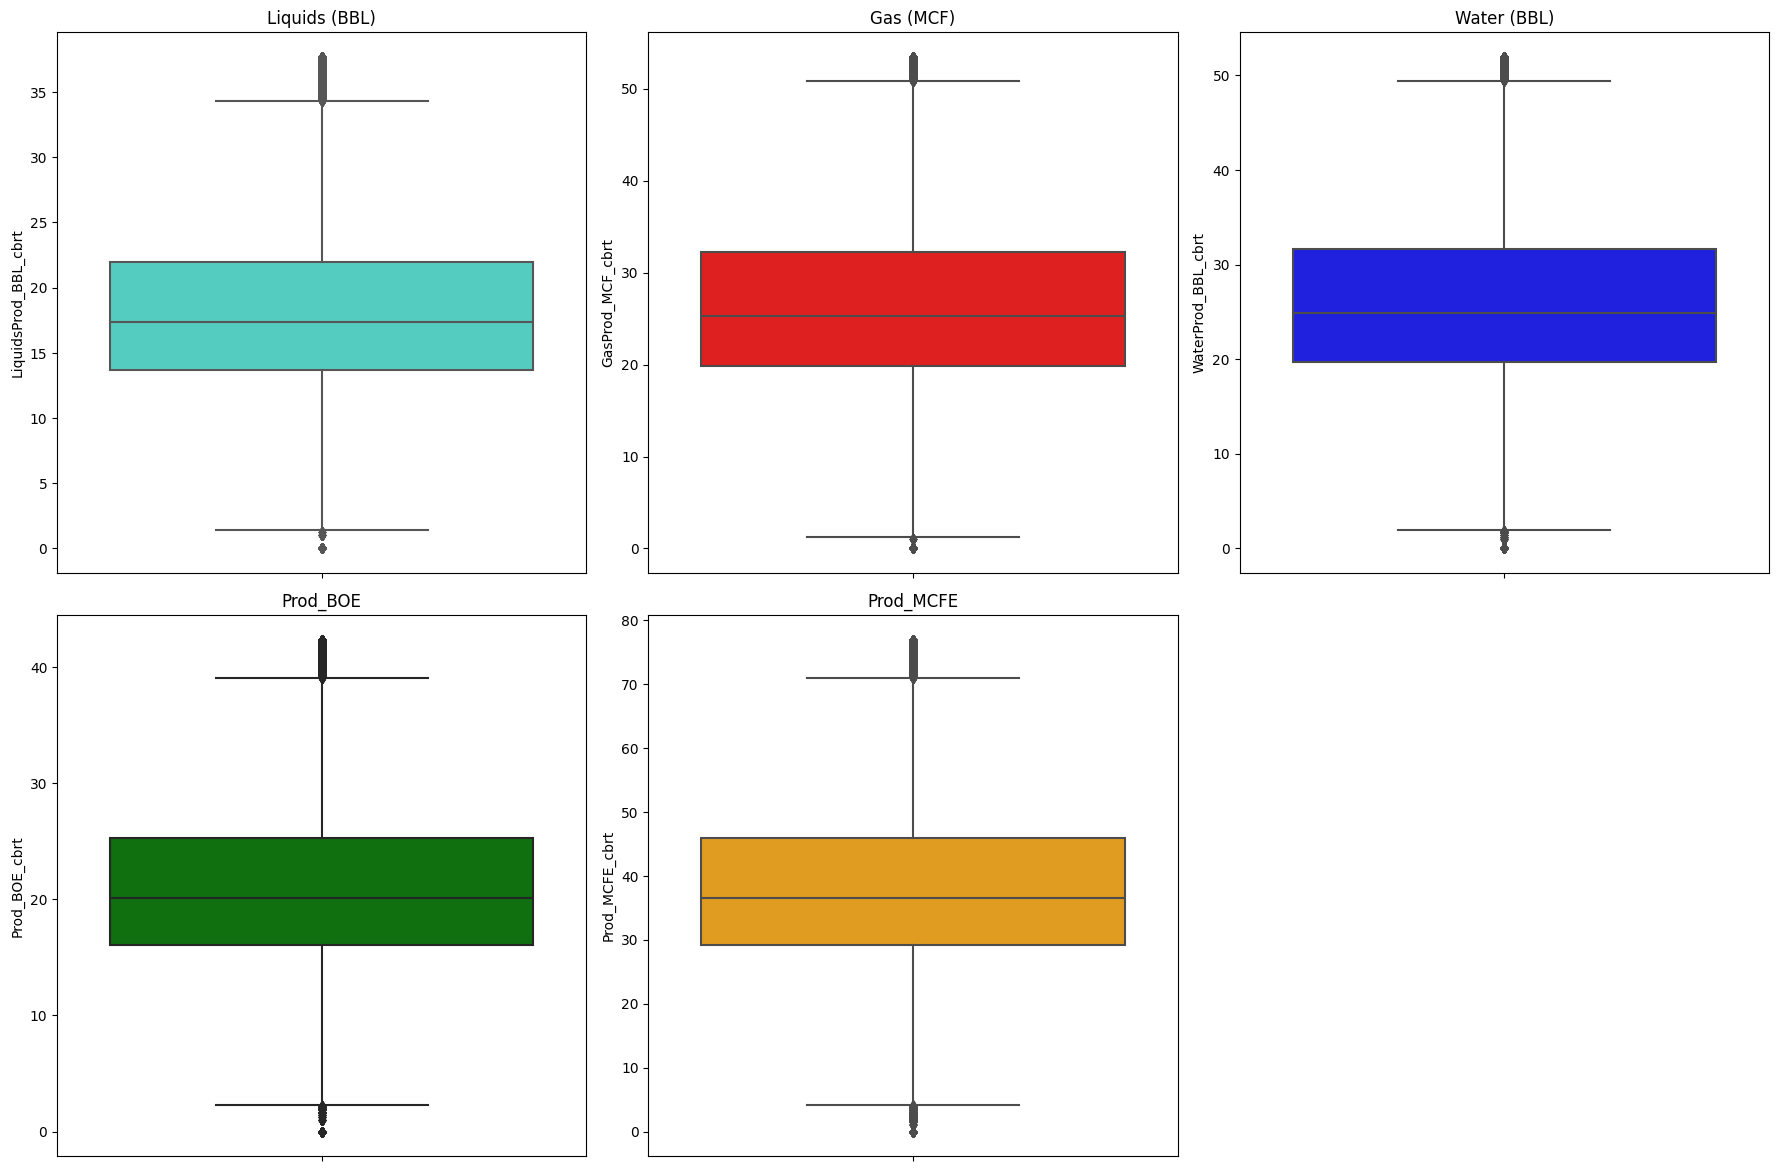

In [11]:
# Boxplots of each production type
warnings.filterwarnings("ignore", category=DeprecationWarning, module="seaborn._oldcore")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.boxplot(data=Prod_Data_Outliers, y='LiquidsProd_BBL_cbrt', ax=axes[0, 0], color='turquoise').set_title('Liquids (BBL)')
sns.boxplot(data=Prod_Data_Outliers, y='GasProd_MCF_cbrt', ax=axes[0, 1], color='red').set_title('Gas (MCF)')
sns.boxplot(data=Prod_Data_Outliers, y='WaterProd_BBL_cbrt', ax=axes[0, 2], color='blue').set_title('Water (BBL)')
sns.boxplot(data=Prod_Data_Outliers, y='Prod_BOE_cbrt', ax=axes[1, 0], color='green').set_title('Prod_BOE')
sns.boxplot(data=Prod_Data_Outliers, y='Prod_MCFE_cbrt', ax=axes[1, 1], color='orange').set_title('Prod_MCFE')

plt.tight_layout()
fig.delaxes(axes[1][2])

All set with the cleaning of the Production dataset! Now we will dive deeper in this table.

## Analysis in Production Data

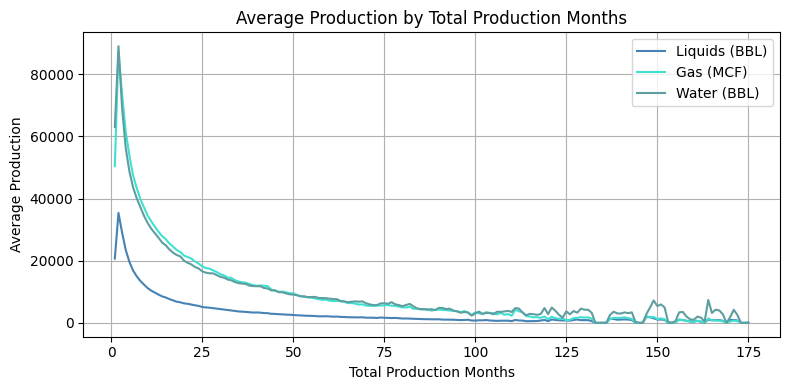

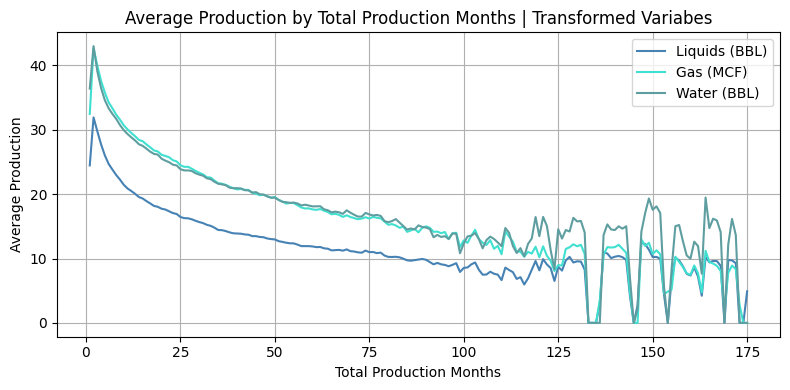

In [12]:
grouped_data = Prod_Data_Outliers.groupby('TotalProdMonths')[['LiquidsProd_BBL', 'GasProd_MCF', 'WaterProd_BBL', 
                                                             'LiquidsProd_BBL_cbrt','GasProd_MCF_cbrt','WaterProd_BBL_cbrt']].mean().reset_index()

# Plotting the line chart
plt.figure(figsize=(8, 4))

# Plotting each production type
plt.plot(grouped_data['TotalProdMonths'], grouped_data['LiquidsProd_BBL'], label='Liquids (BBL)', color='steelblue')
plt.plot(grouped_data['TotalProdMonths'], grouped_data['GasProd_MCF'], label='Gas (MCF)', color='turquoise')
plt.plot(grouped_data['TotalProdMonths'], grouped_data['WaterProd_BBL'], label='Water (BBL)', color='cadetblue')

plt.title('Average Production by Total Production Months')
plt.xlabel('Total Production Months')
plt.ylabel('Average Production')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting the line chart
plt.figure(figsize=(8, 4))

# Plotting each production type
plt.plot(grouped_data['TotalProdMonths'], grouped_data['LiquidsProd_BBL_cbrt'], label='Liquids (BBL)', color='steelblue')
plt.plot(grouped_data['TotalProdMonths'], grouped_data['GasProd_MCF_cbrt'], label='Gas (MCF)', color='turquoise')
plt.plot(grouped_data['TotalProdMonths'], grouped_data['WaterProd_BBL_cbrt'], label='Water (BBL)', color='cadetblue')

plt.title('Average Production by Total Production Months | Transformed Variabes')
plt.xlabel('Total Production Months')
plt.ylabel('Average Production')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The analysis examines production trends using visualizations of liquids, gas, and water output over time. A pronounced decline is observed in average production as the number of months increases, stabilizing later per a standard well decline curve. This highlights the importance of well age in forecasting. 

The transformed variables show an impact in the fluctuations of the last years (after month 100, year 8); while insightful, the curves require cautious interpretation in this period due to data variability.

In [13]:
# Calculating the maximum TotalProdMonths for each API_UWI in the dataset
Max_TotalProdMonths = Prod_Data_Outliers.groupby('API_UWI')['TotalProdMonths'].max().reset_index()
Max_TotalProdMonths = Max_TotalProdMonths.rename(columns={'TotalProdMonths': 'Max_TotalProdMonths'})

#CHATGPT Change for histogram
Max_TotalProdMonths.describe()

,Max_TotalProdMonths
count,2829.000000
mean,37.743726
std,23.520833
min,1.000000
25%,18.000000
50%,34.000000
75%,54.000000
max,175.000000


We can observe that we have different production months for each of the wells. We need to decide how much we could predict ensuring also to have enough performance window. As shown, 25% of the wells have less than 18 full months of information. In other words, this means that we could use 1.5 years (considering both prediction and performance windows) if we lose the information of that 25%. If we want to consider 3 years (1 for prediction and 2 of performance window) we will be working with around 50% of the wells. 

We will start trying with this approach: 1 year for prediction and 2 of performance window, with the only condition of having the full 12 months to test the model. 

In [15]:
#Production Dataset
Prod_Data_2 = pd.merge(Prod_Data_Outliers, Max_TotalProdMonths, left_on='API_UWI', right_on='API_UWI', how='inner')
pd.set_option('display.max_columns',None)

Prod_Data_2['T'] = - (Prod_Data_2['Max_TotalProdMonths'] - Prod_Data_2['TotalProdMonths'] - 12)
Prod_Data_2['Max_TotalProdMonths_T0'] = np.maximum(Prod_Data_2['Max_TotalProdMonths'] - 12, 0)

Prod_Data_3 = Prod_Data_2.loc[Prod_Data_2['T'] >= -24]
Prod_Data_3 = Prod_Data_3.loc[Prod_Data_3['Max_TotalProdMonths'] >= 12]
Prod_Data_3

,API_UWI,ProducingMonth,TotalProdMonths,ProducingDays,Prod_BOE,Prod_MCFE,LiquidsProd_BBL,GasProd_MCF,WaterProd_BBL,CDProd_BOEPerDAY,CDProd_MCFEPerDAY,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,PDProd_BOEPerDAY,PDProd_MCFEPerDAY,PDLiquids_BBLPerDAY,PDGas_MCFPerDAY,PDWater_BBLPerDAY,Prod_BOE_log,Prod_BOE_sqrt,Prod_BOE_cbrt,Prod_MCFE_log,Prod_MCFE_sqrt,Prod_MCFE_cbrt,LiquidsProd_BBL_log,LiquidsProd_BBL_sqrt,LiquidsProd_BBL_cbrt,GasProd_MCF_log,GasProd_MCF_sqrt,GasProd_MCF_cbrt,WaterProd_BBL_log,WaterProd_BBL_sqrt,WaterProd_BBL_cbrt,CDProd_BOEPerDAY_log,CDProd_BOEPerDAY_sqrt,CDProd_BOEPerDAY_cbrt,CDProd_MCFEPerDAY_log,CDProd_MCFEPerDAY_sqrt,CDProd_MCFEPerDAY_cbrt,CDLiquids_BBLPerDAY_log,CDLiquids_BBLPerDAY_sqrt,CDLiquids_BBLPerDAY_cbrt,CDGas_MCFPerDAY_log,CDGas_MCFPerDAY_sqrt,CDGas_MCFPerDAY_cbrt,CDWater_BBLPerDAY_log,CDWater_BBLPerDAY_sqrt,CDWater_BBLPerDAY_cbrt,PDProd_BOEPerDAY_log,PDProd_BOEPerDAY_sqrt,PDProd_BOEPerDAY_cbrt,PDProd_MCFEPerDAY_log,PDProd_MCFEPerDAY_sqrt,PDProd_MCFEPerDAY_cbrt,PDLiquids_BBLPerDAY_log,PDLiquids_BBLPerDAY_sqrt,PDLiquids_BBLPerDAY_cbrt,PDGas_MCFPerDAY_log,PDGas_MCFPerDAY_sqrt,PDGas_MCFPerDAY_cbrt,PDWater_BBLPerDAY_log,PDWater_BBLPerDAY_sqrt,PDWater_BBLPerDAY_cbrt,Max_TotalProdMonths,T,Max_TotalProdMonths_T0
30,30-015-43920,2020-09-01,31,30,4640.0,27841.0,2664.0,11857.0,16911.0,155.0,928.0,89.0,395.0,564.0,155.0,928.0,89.0,395.0,564.0,8.442685,68.117545,16.679102,10.234301,166.856226,30.308302,7.887959,51.613952,13.862602,9.380758,108.889853,22.802980,9.735779,130.042301,25.667866,5.049856,12.449900,5.371685,6.834109,30.463092,9.753998,4.499810,9.433981,4.464745,5.981414,19.874607,7.337234,6.336826,23.748684,8.262149,5.049856,12.449900,5.371685,6.834109,30.463092,9.753998,4.499810,9.433981,4.464745,5.981414,19.874607,7.337234,6.336826,23.748684,8.262149,67,-24,55
31,30-015-43920,2020-10-01,32,31,4776.0,28658.0,2797.0,11876.0,17806.0,154.0,924.0,90.0,383.0,574.0,154.0,924.0,90.0,383.0,574.0,8.471568,69.108610,16.840492,10.263223,169.286739,30.601917,7.936660,52.886671,14.089562,9.382359,108.977062,22.815154,9.787347,133.439125,26.112921,5.043425,12.409674,5.360108,6.829794,30.397368,9.739963,4.510860,9.486833,4.481405,5.950643,19.570386,7.262167,6.354370,23.958297,8.310694,5.043425,12.409674,5.360108,6.829794,30.397368,9.739963,4.510860,9.486833,4.481405,5.950643,19.570386,7.262167,6.354370,23.958297,8.310694,67,-23,55
32,30-015-43920,2020-11-01,33,30,4532.0,27190.0,2649.0,11296.0,18077.0,151.0,906.0,88.0,377.0,603.0,151.0,906.0,88.0,377.0,603.0,8.419139,67.320131,16.548678,10.210641,164.893905,30.070206,7.882315,51.468437,13.836534,9.332292,106.282642,22.437522,9.802451,134.450734,26.244731,5.023881,12.288206,5.325074,6.810142,30.099834,9.676302,4.488636,9.380832,4.447960,5.934894,19.416488,7.224045,6.403574,24.556058,8.448361,5.023881,12.288206,5.325074,6.810142,30.099834,9.676302,4.488636,9.380832,4.447960,5.934894,19.416488,7.224045,6.403574,24.556058,8.448361,67,-22,55
33,30-015-43920,2020-12-01,34,31,4448.0,26685.0,2537.0,11463.0,17506.0,143.0,861.0,82.0,370.0,565.0,143.0,861.0,82.0,370.0,565.0,8.400435,66.693328,16.445797,10.191894,163.355441,29.882877,7.839132,50.368641,13.638716,9.346967,107.065401,22.547554,9.770356,132.310241,25.965437,4.969813,11.958261,5.229322,6.759255,29.342802,9.513370,4.418841,9.055385,4.344481,5.916202,19.235384,7.179054,6.338594,23.769729,8.267029,4.969813,11.958261,5.229322,6.759255,29.342802,9.513370,4.418841,9.055385,4.344481,5.916202,19.235384,7.179054,6.338594,23.769729,8.267029,67,-21,55
34,30-015-43920,2021-01-01,35,31,4149.0,24895.0,2459.0,10141.0,14566.0,134.0,803.0,79.0,327.0,470.0,134.0,803.0,79.0,327.0,470.0,8.330864,64.412732,16.068715,10.122462,157.781494,29.199184,7.807917,49.588305,13.497485,9.224440,100.702532,21.645133,9.586514,120.689685,24.421937,4.905275,11.575837,5.117230,6.689599,28.337255,9.294767,4.382027,8.888194,4.290840,5.793014,18.083141,6.889419,6.154858,21.679483,7.774980,4.905275,11.575837,5.117230,6.689599,28.337255,9.29476

In [16]:
#Dataset with information for the variables in the Pre Period (before T0)
Prod_Data_Pre = Prod_Data_3.loc[Prod_Data_2['T'] <= 0]

#Dataset with information for the variables in the Post Period (after T0)
Prod_Data_Post = Prod_Data_3.loc[Prod_Data_2['T'] > 0]
Prod_Data_Post.head(3)

,API_UWI,ProducingMonth,TotalProdMonths,ProducingDays,Prod_BOE,Prod_MCFE,LiquidsProd_BBL,GasProd_MCF,WaterProd_BBL,CDProd_BOEPerDAY,CDProd_MCFEPerDAY,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,PDProd_BOEPerDAY,PDProd_MCFEPerDAY,PDLiquids_BBLPerDAY,PDGas_MCFPerDAY,PDWater_BBLPerDAY,Prod_BOE_log,Prod_BOE_sqrt,Prod_BOE_cbrt,Prod_MCFE_log,Prod_MCFE_sqrt,Prod_MCFE_cbrt,LiquidsProd_BBL_log,LiquidsProd_BBL_sqrt,LiquidsProd_BBL_cbrt,GasProd_MCF_log,GasProd_MCF_sqrt,GasProd_MCF_cbrt,WaterProd_BBL_log,WaterProd_BBL_sqrt,WaterProd_BBL_cbrt,CDProd_BOEPerDAY_log,CDProd_BOEPerDAY_sqrt,CDProd_BOEPerDAY_cbrt,CDProd_MCFEPerDAY_log,CDProd_MCFEPerDAY_sqrt,CDProd_MCFEPerDAY_cbrt,CDLiquids_BBLPerDAY_log,CDLiquids_BBLPerDAY_sqrt,CDLiquids_BBLPerDAY_cbrt,CDGas_MCFPerDAY_log,CDGas_MCFPerDAY_sqrt,CDGas_MCFPerDAY_cbrt,CDWater_BBLPerDAY_log,CDWater_BBLPerDAY_sqrt,CDWater_BBLPerDAY_cbrt,PDProd_BOEPerDAY_log,PDProd_BOEPerDAY_sqrt,PDProd_BOEPerDAY_cbrt,PDProd_MCFEPerDAY_log,PDProd_MCFEPerDAY_sqrt,PDProd_MCFEPerDAY_cbrt,PDLiquids_BBLPerDAY_log,PDLiquids_BBLPerDAY_sqrt,PDLiquids_BBLPerDAY_cbrt,PDGas_MCFPerDAY_log,PDGas_MCFPerDAY_sqrt,PDGas_MCFPerDAY_cbrt,PDWater_BBLPerDAY_log,PDWater_BBLPerDAY_sqrt,PDWater_BBLPerDAY_cbrt,Max_TotalProdMonths,T,Max_TotalProdMonths_T0
55,30-015-43920,2022-10-01,56,31,3040.0,18238.0,1805.0,7408.0,9379.0,98.0,588.0,58.0,239.0,303.0,98.0,588.0,58.0,239.0,303.0,8.019942,55.136195,14.486313,9.811317,135.048140,26.322415,7.498870,42.485292,12.175657,8.910451,86.069739,19.493971,9.146335,96.845237,21.088815,4.595120,9.899495,4.610436,6.378426,24.248711,8.377719,4.077537,7.615773,3.870877,5.480639,15.459625,6.205822,5.717028,17.406895,6.716570,4.595120,9.899495,4.610436,6.378426,24.248711,8.377719,4.077537,7.615773,3.870877,5.480639,15.459625,6.205822,5.717028,17.406895,6.71657,67,1,55
56,30-015-43920,2022-11-01,57,30,2559.0,15351.0,1545.0,6081.0,9005.0,85.0,512.0,52.0,203.0,300.0,85.0,512.0,52.0,203.0,300.0,7.847763,50.586559,13.678026,9.639001,123.899153,24.853004,7.343426,39.306488,11.560488,8.713089,77.980767,18.252611,9.105646,94.894678,20.804690,4.454347,9.219544,4.396830,6.240276,22.627417,8.000000,3.970292,7.211103,3.732511,5.318120,14.247807,5.877131,5.707110,17.320508,6.694330,4.454347,9.219544,4.396830,6.240276,22.627417,8.000000,3.970292,7.211103,3.732511,5.318120,14.247807,5.877131,5.707110,17.320508,6.69433,67,2,55
57,30-015-43920,2022-12-01,58,30,2943.0,17658.0,1758.0,7110.0,8919.0,95.0,570.0,57.0,229.0,288.0,98.0,589.0,59.0,237.0,297.0,7.987524,54.249424,14.330569,9.779001,132.883408,26.040371,7.472501,41.928511,12.069046,8.869398,84.320816,19.228993,9.096051,94.440457,20.738248,4.564348,9.746794,4.562903,6.347389,23.874673,8.291344,4.060443,7.549834,3.848501,5.438079,15.132746,6.118033,5.666427,16.970563,6.603854,4.595120,9.899495,4.610436,6.380123,24.269322,8.382465,4.094345,7.681146,3.892996,5.472271,15.394804,6.188463,5.697093,17.233688,6.67194,67,3,55


## Target variable for the Classification Model

In [17]:
#Create a dataset with potential target variables for the classification model 

# Group and aggregate data for the pre period
Prod_Data_Summary_Pre = Prod_Data_Pre.groupby(['API_UWI', 'Max_TotalProdMonths_T0']).agg(    
    LiquidsProd_BBL=('LiquidsProd_BBL', 'mean'),
    GasProd_MCF=('GasProd_MCF', 'mean'),
    LiquidsProd_BBL_cbrt=('LiquidsProd_BBL_cbrt', 'mean'),
    GasProd_MCF_cbrt=('GasProd_MCF_cbrt', 'mean')
).reset_index()

# Group and aggregate data for the post period
Prod_Data_Summary_Post = Prod_Data_Post.groupby(['API_UWI', 'Max_TotalProdMonths_T0']).agg(
    LiquidsProd_BBL=('LiquidsProd_BBL', 'mean'),
    GasProd_MCF=('GasProd_MCF', 'mean'),
    LiquidsProd_BBL_cbrt=('LiquidsProd_BBL_cbrt', 'mean'),
    GasProd_MCF_cbrt=('GasProd_MCF_cbrt', 'mean')
).reset_index()

# Function to calculate the slope of the linear regression (trend)
def calculate_slope(df, y_column):
    if len(df) < 2:  # We need at least two points to calculate a slope
        return np.nan
    df = df.sort_values('ProducingMonth')
    X = np.arange(len(df)).reshape(-1, 1)  # We use the index as the independent variable
    y = df[y_column].values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    return model.coef_[0][0]  # We return the slope of the regression

# Calculate the trends for GasProd_MCF and LiquidsProd_BBL in Prod_Data_Post
trends = Prod_Data_Post.groupby(['API_UWI', 'Max_TotalProdMonths_T0']).apply(lambda group: pd.Series({
    'GasProd_MCF_Trend': calculate_slope(group, 'GasProd_MCF'),
    'LiquidsProd_BBL_Trend': calculate_slope(group, 'LiquidsProd_BBL')
})).reset_index()

# Merge the calculated trends with Prod_Data_Summary_Post
Prod_Data_Summary_Post = pd.merge(Prod_Data_Summary_Post, trends, on=['API_UWI', 'Max_TotalProdMonths_T0'], how='left')
Prod_Data_Summary_Post

,API_UWI,Max_TotalProdMonths_T0,LiquidsProd_BBL,GasProd_MCF,LiquidsProd_BBL_cbrt,GasProd_MCF_cbrt,GasProd_MCF_Trend,LiquidsProd_BBL_Trend
0,30-015-38612,97,1306.333333,4833.916667,10.480489,16.723862,-222.213287,-135.776224
1,30-015-38614,112,1507.000000,4030.000000,11.385738,15.794015,-112.412587,-51.230769
2,30-015-38624,104,657.333333,4541.750000,8.167607,16.180856,-224.472028,-42.958042
3,30-015-38669,9,551.333333,1452.166667,7.716635,10.500161,-47.517483,-16.629371
4,30-015-41089,89,578.083333,4968.166667,8.198227,16.080019,-543.790210,-18.520979
...,...,...,...,...,...,...,...,...
2440,30-025-49726,1,20324.416667,29142.083333,27.013376,30.247153,-3131.255245,-1686.024476
2441,30-025-49834,0,19472.176667,42363.416667,25.711997,33.201409,-6923.618881,-3121.438182
2442,30-025-49835,0,19790.510000,46457.250000,25.316982,33.270766,-6319.269231,-2745.508112
2443,30-025-49836,0,23189.426667,47005.416667,27.353241,34.020230,-7387.849650,-3173.497622


## Attributes & Additional Sources

### Metadata Dataset

In [18]:
Metadata = pd.read_excel("./data/Metadata.xlsx", sheet_name="env_csv-Wells-35f0f_2023-11-28", engine='openpyxl')
pd.set_option('display.max_columns',None)
Metadata.head()

,API_UWI,Unformatted_API_UWI,API_UWI_12,Unformatted_API_UWI_12,API_UWI_14,Unformatted_API_UWI_14,WellID,CompletionID,WellPadID,WellPadDirection,ENVWellGrouping,CompletionNumber,WellName,Country,StateProvince,County,Lease,LeaseName,ENVOperator,RawOperator,InitialOperator,ENVTicker,ENV_Peer_Group,ENV_Stock_Exchange,ENVWellServiceProvider,ENVProdWellType,StateWellType,ENVWellType,ENVProducingMethod,ENVRegion,ENVBasin,ENVPlay,ENVSubPlay,ENVInterval,ENVIntervalSource,ENVSpacingAssumption,ENVWellStatus,ENVWellboreStatus,OnConfidential,OffConfidentialDate,Trajectory,ENVWellboreType,Formation,FirstProdDate,Latitude,Longitude,Latitude_BH,Longitude_BH,TVD_FT,MD_FT,District,Field,Survey,Block,Abstract,Platform,Section,Township,Range,Section_Township_Range,Unit_Name,WellNumber,SurfaceLatitudeLongitudeSource,PlugDate,PlugbackMeasuredDepth_FT,PlugbackTrueVerticalDepth_FT,AvgBreakdownPressure_PSI,AvgClusterSpacingPerStage_FT,AvgClusterSpacing_FT,AvgFracGradient_PSIPerFT,AvgISIP_PSI,AvgMillTime_Min,AvgPortSleeveOpeningPressure_PSI,AvgShotsPerCluster,AvgShotsPerFt,AvgTreatmentPressure_PSI,AvgTreatmentRate_BBLPerMin,"ClustersPer1,000Ft",ClustersPerStage,"ShotsPer1,000Ft",ShotsPerStage,TotalShots,AvgFluidPerCluster_BBL,AvgFluidPerShot_BBL,AvgFluidPerStage_BBL,FracRigOnsiteDate,FracRigReleaseDate,AvgProppantPerCluster_LBS,AvgProppantPerShot_LBS,AvgProppantPerStage_LBS,StimulatedStages,TotalClusters,Vintage,FirstProdQuarter,FirstProdMonth,ENVElevationKB_FT,ENVElevationKBSource,ENVElevationGL_FT,ENVElevationGLSource,ElevationKB_FT,ElevationGL_FT,CoordinateSource,PermitApprovedDate,PermitSubmittedDate,SpudDate,DrillingEndDate,RigReleaseDate,CompletionDate,FirstRigDay,ENVCompInsertedDate,StateFileNumber,ENVFracJobType,ENVFluidType,CompletionTime_DAYS,CompletionDesign,PermitToSpud_DAYS,SpudToRigRelease_DAYS,SpudToCompletion_DAYS,SpudToSales_DAYS,SoakTime_DAYS,NumberOfStrings,UpperPerf_FT,LowerPerf_FT,PerfInterval_FT,LateralLength_FT,FracStages,AverageStageSpacing_FT,ENVProppantBrand,ProppantLoading_LBSPerGAL,ENVProppantType,ProppantIntensity_LBSPerFT,Proppant_LBS,TotalWaterPumped_GAL,WaterIntensity_GALPerFT,TotalFluidPumped_BBL,FluidIntensity_BBLPerFT,AcidVolume_BBL,Bottom_Hole_Temp_DEGF,Biocide_LBS,Breaker_LBS,Buffer_LBS,ClayControl_LBS,CrossLinker_LBS,FrictionReducer_LBS,GellingAgent_LBS,IronControl_LBS,ScaleInhibitor_LBS,Surfactant_LBS,Energizer_LBS,Diverter_LBS,TestDate,ChokeSize_64IN,TestRate_BOEPerDAY,TestRate_BOEPerDAYPer1000FT,TestRate_MCFEPerDAY,OilTestRate_BBLPerDAY,OilTestRate_BBLPerDAYPer1000FT,GasTestRate_MCFPerDAY,GasTestRate_MCFPerDAYPer1000FT,WaterTestRate_BBLPerDAY,WaterTestRate_BBLPerDAYPer1000Ft,WaterDepth,TestWHLiquids_PCT,CasingPressure_PSI,FlowingTubingPressure_PSI,ShutInPressure_PSI,OilProdPriorTest_BBL,OilTestMethodName,OilGravity_API,GasGravity_SG,First3MonthProd_BOE,First3MonthProd_BOEPer1000FT,First3MonthGas_MCF,First3MonthGas_MCFPer1000FT,First3MonthProd_MCFE,First3MonthProd_MCFEPer1000FT,First3MonthOil_BBL,First3MonthOil_BBLPer1000FT,First3MonthWater_BBL,First6MonthProd_BOE,First6MonthProd_BOEPer1000FT,First6MonthGas_MCF,First6MonthGas_MCFPer1000FT,First6MonthProd_MCFE,First6MonthProd_MCFEPer1000FT,First6MonthOil_BBL,First6MonthOil_BBLPer1000FT,First6MonthWater_BBL,First9MonthProd_BOE,First9MonthProd_BOEPer1000FT,First9MonthGas_MCF,First9MonthGas_MCFPer1000FT,First9MonthProd_MCFE,First9MonthProd_MCFEPer1000FT,First9MonthOil_BBL,First9MonthOil_BBLPer1000FT,First9MonthWater_BBL,First12MonthProd_BOE,First12MonthProd_BOEPer1000FT,First12MonthGas_MCF,First12MonthGas_MCFPer1000FT,First12MonthProd_MCFE,First12MonthProd_MCFEPer1000FT,First12MonthOil_BBL,First12MonthOil_BBLPer1000FT,First12MonthWater_BBL,First36MonthProd_BOE,First36MonthProd_BOEPer1000FT,First36MonthGas_MCF,First36MonthGas_MCFPer1000FT,First36MonthProd_MCFE,First36MonthProd_MCFEPer1000FT,First36MonthOil_BBL,First36MonthOil_BBLPer1000FT,First36MonthWater_BBL,First36MonthWaterProductionBBLPer1000Ft,PeakProductionDate,MonthsToPeakProduction,PeakProd_BOE,PeakProd_BOEPe

This database has a lot of useless variables, we can easily delete the ones that are empty or have the same values to focus on the ones that can give us insights. 

In [19]:
def remove_low_variance_columns_and_report(df, threshold=0.98):
    original_shape = df.shape
    dropped_columns = []
    
    for col in df.columns:
        most_common_pct = (df[col].value_counts(dropna=False).iloc[0] / len(df))
        if most_common_pct >= threshold:
            dropped_columns.append(col)
            df = df.drop(columns=[col])
    new_shape = df.shape
    
    #print(f"Dropped columns: {dropped_columns}")
    print(f"Original shape: {original_shape}")
    print(f"New shape: {new_shape}")
    return df

Metadata = remove_low_variance_columns_and_report(Metadata)

Original shape: (2863, 505)
New shape: (2863, 436)


This table will be used for the classification Machine Learning model; hence we will exclude the production and financial variables and focus in the characteristics that can help us classify the wells according to the attributes that we can know before investing in the wells. In the following box, we can observe the useful variables grouped according to their nature.

In [20]:
geographical_features = ["County", "Latitude", "Longitude","Latitude_BH", "Longitude_BH", "TVD_FT", "MD_FT", "Section", "Township",
    "Range", "TopOfZone_FT", "BottomOfZone_FT", "SubseaTopDepth_FT", "SubseaBaseDepth_FT",
    "Isopach_FT", "GammaRay_API", "BulkDensity_GPerCC", "Resistivity_OHMSM", "DensityPorosity_PCT","EffectivePorosity_PCT",
    "ClayVolume_PCT", "NonClayVolume_PCT", "WaterSaturation_PCT","PhiH_FT", "HCPV_PCT", "HeightOfHCPV_FT", "TotalOrganicCarbon_WTPCT"]

well_features = ["WellPadDirection","StateWellType", "ENVWellType", "ENVProducingMethod", "ENVSubPlay", "ENVInterval",
    "ENVSpacingAssumption", "ENVWellboreType", "PlugbackMeasuredDepth_FT", "PlugbackTrueVerticalDepth_FT",
    "AvgFluidPerStage_BBL", "AvgProppantPerStage_LBS", "Vintage", "ENVElevationKB_FT","ENVElevationKBSource",
    "ENVElevationGL_FT", "ENVElevationGLSource", "ElevationKB_FT", "ElevationGL_FT", "CoordinateSource", "NumberOfStrings",
    "UpperPerf_FT", "LowerPerf_FT", "PerfInterval_FT", "LateralLength_FT", "FracStages", "AverageStageSpacing_FT",
    "ProppantLoading_LBSPerGAL", "ENVProppantType", "ProppantIntensity_LBSPerFT", "Proppant_LBS",
    "TotalWaterPumped_GAL", "WaterIntensity_GALPerFT", "TotalFluidPumped_BBL", "FluidIntensity_BBLPerFT", "AcidVolume_BBL",
    "Biocide_LBS", "Breaker_LBS", "Buffer_LBS", "ClayControl_LBS", "CrossLinker_LBS", "FrictionReducer_LBS",
    "GellingAgent_LBS", "IronControl_LBS", "ScaleInhibitor_LBS", "Surfactant_LBS","Diverter_LBS", "TestDate",
    "ChokeSize_64IN", "TestRate_BOEPerDAY",  "TestRate_BOEPerDAYPer1000FT","TestRate_MCFEPerDAY","OilTestRate_BBLPerDAY",
    "OilTestRate_BBLPerDAYPer1000FT", "GasTestRate_MCFPerDAY", "GasTestRate_MCFPerDAYPer1000FT", "WaterTestRate_BBLPerDAY",
    "WaterTestRate_BBLPerDAYPer1000Ft","TestWHLiquids_PCT", "CasingPressure_PSI", "FlowingTubingPressure_PSI",
    "OilTestMethodName", "OilGravity_API","Tortuosity","ToeAngle_DEG", "AzimuthFromGridNorth_DEG"]

density_features = ["ParentChildAnyZone","ParentChildSameZone","BoundedAnyZone","BoundedSameZone","Bounded100dVZoneCurrent",
                    "BoundedAnyZoneInitial","BoundedSameZoneInitial","Bounded100dVZoneInitial","CoCompletion",
                    "WellDensityAnyZone","WellDensitySameZone","WellsPerSectionAnyZone","WellsPerSectionSameZone",
                    "ImpliedWellSpacingSameZone_FT","AvgHzDistAtDrillTimeSameZone_FT","AvgVtDistAtDrillTimeSameZone_FT",
                    "ClosestHzDistAtDrillTimeSameZone_FT","ClosestVtDistAtDrillTimeSameZone_FT",
                    "AvgHzDistAtDrillTimeAnyZone_FT","AvgVtDistAtDrillTimeAnyZone_FT","ClosestHzDistAtDrillTimeAnyZone_FT",
                    "ClosestVtDistAtDrillTimeAnyZone_FT","ClosestHzDistAtDrillTime100dVZone_FT",
                    "ClosestVtDistAtDrillTime100dVZone_FT","AvgHzDistAtDrillTime100dVZone_FT",
                    "AvgVtDistAtDrillTime100dVZone_FT","AvgHzDistSameZone_FT","AvgVtDistSameZone_FT",
                    "ClosestHzDistSameZone_FT","ClosestVtDistSameZone_FT","AvgHzDistAnyZone_FT","AvgVtDistAnyZone_FT",
                    "ClosestHzDistAnyZone_FT","ClosestVtDistAnyZone_FT","ClosestHzDist100dVZone_FT","ClosestVtDist100dVZone_FT",
                    "AvgHzDist100dVZone_FT","AvgVtDist100dVZone_FT","ClosestAnyProdMonthDiff","AverageAnyProdMonthDiff",
                    "ClosestSameProdMonthDiff","AverageSameProdMonthDiff","Closest100dVProdMonthDiff",
                    "Average100dVProdMonthDiff","ENVSpacingClass_AnyZone","ENVSpacingClass_SameZone",
                    "ENVSpacingClass_Within100","ENVSpacingClass_AnyZoneAtInitialClass","ENVSpacingClass_SameZoneAtInitialClass",
                    "ENVSpacingClass_Vertical100AtInitialClass","ParentChildVertical100","ParentChildAnyZoneAtInitial",
                    "ParentChildSameZoneAtInitial","ParentChildVertical100AtInitial","TestRate_MCFEPerDAYPer1000FT",
                    "Avg3DDistSameZone_FT","VerticalBoundedSameZoneAtInitial","VerticalBoundedSameZoneAtCurrent",
                    "NearNeighborCountSameZone","Closest3DDistAtDrillTimeAnyZone_FT","Closest3DDistAtDrillTimeSameZone_FT",
                    "Avg3DDistAtDrillTimeAnyZone_FT","Avg3DDistAtDrillTimeSameZone_FT","Closest3DDistToParentAtDrillTimeAnyZone_FT",
                    "Closest3DDistToParentAtDrillTimeSameZone_FT","Avg3DDistToParentAtDrillTimeAnyZone_FT",
                    "Avg3DDistToParentAtDrillTimeSameZone_FT","ClosestHzDistToParentAtDrillTimeAnyZone_FT","ClosestHzDistToParentAtDrillTimeSameZone_FT",
                    "AvgHzDistToParentAtDrillTimeAnyZone_FT","AvgHzDistToParentAtDrillTimeSameZone_FT",
                    "ClosestVtDistToParentAtDrillTimeAnyZone_FT","ClosestVtDistToParentAtDrillTimeSameZone_FT",
                    "AvgVtDistToParentAtDrillTimeAnyZone_FT","AvgVtDistToParentAtDrillTimeSameZone_FT","ParentWellCountAtDrillTimeAnyZone",
                    "ParentWellCountAtDrillTimeSameZone","VerticalBoundedAtDrillTimeAnyZone","NearNeighborCountAtDrillTimeAnyZone",
                    "NearNeighborCountAtDrillTimeSameZone","Closest3DDistAnyZone_FT","Closest3DDistSameZone_FT","Avg3DDistAnyZone_FT",	"VerticalBoundedAnyZone",	"NearNeighborCountAnyZone",	"Closest3DDistAtDrillTime100dVZone_FT",	"Avg3DDistAtDrillTime100dVZone_FT",	"Closest3DDistToParentAtDrillTime100dVZone_FT",	"Avg3DDistToParentAtDrillTime100dVZone_FT",	"ClosestHzDistToParentAtDrillTime100dVZone_FT",	"AvgHzDistToParentAtDrillTime100dVZone_FT",	"ParentWellCountAtDrillTime100dVZone",	"NearNeighborCountAtDrillTime100dVZone",	"Closest3DDist100dVZone_FT",	"Avg3DDist100dVZone_FT",	"NearNeighborCount100dVZone",	"ClosestVtDistToParentAtDrillTime100dVZone_FT",	"AvgVtDistToParentAtDrillTime100dVZone_FT",	"VerticalBoundedAtDrillTime100dVZone",	"VerticalBounded100dVZone",	"VerticalParentChildAtDrillTimeSameZone",	"EnvVerticalSpacingClassAtDrillTimeSameZone",	"VerticalParentChildSameZone",	"EnvVerticalSpacingClassSameZone",	"VerticalParentChildAtDrillTimeAnyZone",	"EnvVerticalSpacingClassAtDrillTimeAnyZone",	"VerticalParentChildAnyZone",	"EnvVerticalSpacingClassAnyZone",	"VerticalParentChildAtDrillTime100dVZone",	"EnvVerticalSpacingClassAtDrillTime100dVZone",	"VerticalParentChild100dVZone",	"EnvVerticalSpacingClass100dVZone"]


In [21]:
Metadata=Metadata[['API_UWI'] + well_features + geographical_features + density_features]
Metadata.shape

(2863, 206)

Further reduction is going to be performed in the next steps.

### Geojson file


In [22]:
wells_json = gpd.read_file("./data/New_Mexico_Oil_and_Gas_Wells.geojson")
pd.set_option('display.max_columns',None)
wells_json.head()

,OBJECTID,id,name,type,status,sub_type_code,ogrid,ogrid_name,district_code,district,county_code,county,ulstr,latitude,longitude,projection,directional_status,details,files,year_spudded,lease_type,measured_vertical_depth,true_vertical_depth,pool_id_list,last_production_date,plug_date,GlobalID,geometry
0,1,30-045-08708,DUSTIN #001,Gas,Active,None,372171,HILCORP ENERGY COMPANY,3,Aztec,45,San Juan,K-06-29N-12W,36.752815,-108.142349,NAD83,V,https://wwwapps.emnrd.nm.gov/ocd/ocdpermitting...,http://ocdimage.emnrd.nm.gov/imaging/WellFileV...,1961,Private,6130,6130,[71599] BASIN DAKOTA (PRORATED GAS),2023-11-01T07:00:00+00:00,9999-12-31T06:59:59+00:00,{164D4436-E73B-4404-B5A2-877F27CAEE22},POINT (-108.14236 36.75282)
1,2,30-005-61101,SLAYTON FEDERAL #001,Gas,Plugged (site released),,330238,"Solis Partners, L.L.C.",2,Artesia,5,Chaves,D-01-08S-26E,33.654388,-104.256546,NAD83,V,https://wwwapps.emnrd.nm.gov/ocd/ocdpermitting...,http://ocdimage.emnrd.nm.gov/imaging/WellFileV...,9999,Federal,5000,5000,"[82730] PECOS SLOPE, ABO (GAS)",2001-05-01T07:00:00+00:00,9999-12-31T06:59:59+00:00,{DD846FAC-9CAE-4B50-8749-90B417BFA5DD},POINT (-104.25656 33.65439)
2,3,30-005-62477,IRWIN FEDERAL #001,Gas,Active,None,330238,"Solis Partners, L.L.C.",2,Artesia,5,Chaves,M-13-07S-26E,33.701931,-104.256378,NAD83,V,https://wwwapps.emnrd.nm.gov/ocd/ocdpermitting...,http://ocdimage.emnrd.nm.gov/imaging/WellFileV...,1987,Federal,0,99999,"[82730] PECOS SLOPE, ABO (GAS)",2023-11-01T07:00:00+00:00,9999-12-31T06:59:59+00:00,{DBD9BD69-024A-4FE9-85FD-E71395E355B6},POINT (-104.25639 33.70194)
3,4,30-025-40594,BUFFLEHEAD 10 FEDERAL #002H,Oil,Active,None,217955,"COG PRODUCTION, LLC",1,Hobbs,25,Lea,A-10-26S-32E,32.064159,-103.655739,NAD83,H,https://wwwapps.emnrd.nm.gov/ocd/ocdpermitting...,http://ocdimage.emnrd.nm.gov/imaging/WellFileV...,2012,Federal,13856,9520,"[97838] JENNINGS, UPPER BONE SPRING SHALE",2023-10-01T07:00:00+00:00,9999-12-31T06:59:59+00:00,{456B8F84-CD72-4C62-A8CA-170F606ECF58},POINT (-103.65575 32.06416)
4,5,30-025-24915,HUGH 689-C #003,Oil,Plugged (site released),,3002,BTA OIL PRODUCERS,1,Hobbs,25,Lea,N-06-12S-33E,33.302666,-103.655617,NAD83,,https://wwwapps.emnrd.nm.gov/ocd/ocdpermitting...,http://ocdimage.emnrd.nm.gov/imaging/WellFileV...,1900,State,0,10500,"[3820] BAGLEY, PERMO PENN, NORTH",9999-12-31T06:59:59+00:00,1900-01-01T07:00:01+00:00,{B452AC8F-7052-42EF-8E46-B15B4CDE2DC9},POINT (-103.65563 33.30267)


 The JSON can be joined with the Metadata using the variables: `id`=`API_UWI`; it has an overlap with some of the variables (latitude, longitude), but has other variables that can complement the analysis, such as `ogrid`, `directional_status`, `lease_type`, `status` and `district`. It also has the `geometry` of the well in a geojson format that could be useful for the analysis.

In [23]:
wells_json = wells_json[['id', 'ogrid', 'directional_status', 'lease_type', 'status', 'district', 'geometry']]
wells_json

,id,ogrid,directional_status,lease_type,status,district,geometry
0,30-045-08708,372171,V,Private,Active,Aztec,POINT (-108.14236 36.75282)
1,30-005-61101,330238,V,Federal,Plugged (site released),Artesia,POINT (-104.25656 33.65439)
2,30-005-62477,330238,V,Federal,Active,Artesia,POINT (-104.25639 33.70194)
3,30-025-40594,217955,H,Federal,Active,Hobbs,POINT (-103.65575 32.06416)
4,30-025-24915,3002,,State,Plugged (site released),Hobbs,POINT (-103.65563 33.30267)
...,...,...,...,...,...,...,...
132975,30-025-52473,331595,H,State,New,Hobbs,POINT (-103.51218 32.70869)
132976,30-025-52474,331595,H,State,New,Hobbs,POINT (-103.50833 32.70897)
132977,30-015-54637,372043,H,Federal,New,Artesia,POINT (-104.29296 32.12469)
132978,30-015-54638,372043,H,Federal,New,Artesia,POINT (-104.29288 32.12462)


In [24]:
# Merge of both tables for future analysis
Metadata_JSON = pd.merge(Metadata, wells_json, left_on='API_UWI', right_on='id', how='inner')
pd.set_option('display.max_columns',None)
Metadata_JSON.shape

(2863, 213)

In [25]:
#Merge tables
#Prod_Classify = pd.merge(Prod_Data_Summary_Post, Prod_Data_Summary_Pre, left_on='API_UWI', right_on='API_UWI', how='inner')
Metadata_Prod_Classify = pd.merge(Prod_Data_Summary_Post, Metadata_JSON, left_on='API_UWI', right_on='API_UWI', how='inner')

### Proximity to Water Sources


In this code we are creating additional variables related to the proximity of water (salt and fresh) according to determined radios around the location of the well. 

In [26]:
# Record the start time
start_time = datetime.now()

# Update osmnx settings
ox.settings.use_cache = True
ox.settings.log_console = True

# Get New Mexico's boundary as a GeoDataFrame
gdf_new_mexico = ox.geocode_to_gdf('New Mexico, USA')

# Get water bodies in New Mexico
tags = {'natural': 'water'}
gdf_water_bodies = ox.geometries_from_polygon(gdf_new_mexico.geometry.iloc[0], tags)

# Simplify gdf_water_bodies to include only geometry and a simplified classification of water
# Assuming 'water' tagged as 'lake', 'river', 'pond' is freshwater and 'sea' is saltwater.
# This is a simplification and might not account for all types of water bodies accurately.
gdf_water_bodies['water_type'] = 'freshwater'  # Default assumption
gdf_water_bodies.loc[gdf_water_bodies['water'] == 'sea', 'water_type'] = 'saltwater'

# Keep only the necessary columns: geometry and water_type
gdf_water_bodies = gdf_water_bodies[['geometry', 'water_type']]

# Record the end time and calculate the duration
end_time = datetime.now()
duration = end_time - start_time

print(f"Operation completed in: {duration}")
gdf_water_bodies

Operation completed in: 0:00:13.849205


geometry  \
element_type osmid                                                           
way          443215459   POLYGON ((-108.46613 31.66420, -108.46606 31.6...   
             443451696   POLYGON ((-108.50984 31.34961, -108.51003 31.3...   
             594393805   POLYGON ((-108.53039 31.33612, -108.53022 31.3...   
             594393806   POLYGON ((-108.53008 31.33441, -108.53009 31.3...   
             804454721   POLYGON ((-108.54084 31.79525, -108.54054 31.7...   
...                                                                    ...   
             48336550    POLYGON ((-108.86220 36.81240, -108.86209 36.8...   
             48336664    POLYGON ((-108.79854 36.94720, -108.79866 36.9...   
             48336666    POLYGON ((-108.83345 36.93374, -108.83338 36.9...   
             1137109891  POLYGON ((-108.88390 36.70168, -108.88418 36.7...   
relation     2872583     POLYGON ((-109.03689 37.00606, -109.03677 37.0...   

                         water_type  
element_type osmid                   
way          443215459   freshwater  
             443451696   freshwater  
             594393805   freshwater  
             594393806   freshwater  
             804454721   freshwater  
...                             ...  
             48336550    freshwater  
             48336664    freshwater  
             48336666    freshwater  
             1137109891  freshwater  
relation     2872583     freshwater  

[17350 rows x 2 columns]

In [27]:
# Convert Metadata_MV to a GeoDataFrame
gdf_wells = gpd.GeoDataFrame(Metadata_Prod_Classify, geometry=gpd.points_from_xy(Metadata_Prod_Classify['Longitude'], Metadata_Prod_Classify['Latitude']))
gdf_wells.set_crs(epsg=4326, inplace=True)

# Define distances in meters
distances = [250, 500, 750, 1000]

# Function to compute presence of water within specified distances
def water_presence(gdf_wells, gdf_water_bodies, distances):
    # Initialize columns for presence flags
    for distance in distances:
        gdf_wells[f'Freshwater_{distance}'] = 0
        gdf_wells[f'Saltwater_{distance}'] = 0

    # Spatial index for water bodies for efficient querying
    water_sindex = gdf_water_bodies.sindex

    # Iterate over wells
    for idx, well in gdf_wells.iterrows():
        # Buffer the well location by each distance
        for distance in distances:
            well_buffer = well.geometry.buffer(distance / 111320)  # Rough conversion to degrees
            possible_matches_index = list(water_sindex.intersection(well_buffer.bounds))
            possible_matches = gdf_water_bodies.iloc[possible_matches_index]

            # Check for any water body within the buffer
            actual_matches = possible_matches[possible_matches.intersects(well_buffer)]

            # If there are matches, set the presence flag to True
            if not actual_matches.empty:
                if any(actual_matches['water_type'] == 'freshwater'):
                    gdf_wells.at[idx, f'Freshwater_{distance}'] = 1
                if any(actual_matches['water_type'] == 'saltwater'):
                    gdf_wells.at[idx, f'Saltwater_{distance}'] = 1

    return gdf_wells

# Apply the function
Metadata_Prod_Classify_full = water_presence(gdf_wells, gdf_water_bodies, distances)

# Now gdf_wells includes boolean flags indicating the presence of freshwater/saltwater within the specified distances
Metadata_Prod_Classify_full

,API_UWI,Max_TotalProdMonths_T0,LiquidsProd_BBL,GasProd_MCF,LiquidsProd_BBL_cbrt,GasProd_MCF_cbrt,GasProd_MCF_Trend,LiquidsProd_BBL_Trend,WellPadDirection,StateWellType,ENVWellType,ENVProducingMethod,ENVSubPlay,ENVInterval,ENVSpacingAssumption,ENVWellboreType,PlugbackMeasuredDepth_FT,PlugbackTrueVerticalDepth_FT,AvgFluidPerStage_BBL,AvgProppantPerStage_LBS,Vintage,ENVElevationKB_FT,ENVElevationKBSource,ENVElevationGL_FT,ENVElevationGLSource,ElevationKB_FT,ElevationGL_FT,CoordinateSource,NumberOfStrings,UpperPerf_FT,LowerPerf_FT,PerfInterval_FT,LateralLength_FT,FracStages,AverageStageSpacing_FT,ProppantLoading_LBSPerGAL,ENVProppantType,ProppantIntensity_LBSPerFT,Proppant_LBS,TotalWaterPumped_GAL,WaterIntensity_GALPerFT,TotalFluidPumped_BBL,FluidIntensity_BBLPerFT,AcidVolume_BBL,Biocide_LBS,Breaker_LBS,Buffer_LBS,ClayControl_LBS,CrossLinker_LBS,FrictionReducer_LBS,GellingAgent_LBS,IronControl_LBS,ScaleInhibitor_LBS,Surfactant_LBS,Diverter_LBS,TestDate,ChokeSize_64IN,TestRate_BOEPerDAY,TestRate_BOEPerDAYPer1000FT,TestRate_MCFEPerDAY,OilTestRate_BBLPerDAY,OilTestRate_BBLPerDAYPer1000FT,GasTestRate_MCFPerDAY,GasTestRate_MCFPerDAYPer1000FT,WaterTestRate_BBLPerDAY,WaterTestRate_BBLPerDAYPer1000Ft,TestWHLiquids_PCT,CasingPressure_PSI,FlowingTubingPressure_PSI,OilTestMethodName,OilGravity_API,Tortuosity,ToeAngle_DEG,AzimuthFromGridNorth_DEG,County,Latitude,Longitude,Latitude_BH,Longitude_BH,TVD_FT,MD_FT,Section,Township,Range,TopOfZone_FT,BottomOfZone_FT,SubseaTopDepth_FT,SubseaBaseDepth_FT,Isopach_FT,GammaRay_API,BulkDensity_GPerCC,Resistivity_OHMSM,DensityPorosity_PCT,EffectivePorosity_PCT,ClayVolume_PCT,NonClayVolume_PCT,WaterSaturation_PCT,PhiH_FT,HCPV_PCT,HeightOfHCPV_FT,TotalOrganicCarbon_WTPCT,ParentChildAnyZone,ParentChildSameZone,BoundedAnyZone,BoundedSameZone,Bounded100dVZoneCurrent,BoundedAnyZoneInitial,BoundedSameZoneInitial,Bounded100dVZoneInitial,CoCompletion,WellDensityAnyZone,WellDensitySameZone,WellsPerSectionAnyZone,WellsPerSectionSameZone,ImpliedWellSpacingSameZone_FT,AvgHzDistAtDrillTimeSameZone_FT,AvgVtDistAtDrillTimeSameZone_FT,ClosestHzDistAtDrillTimeSameZone_FT,ClosestVtDistAtDrillTimeSameZone_FT,AvgHzDistAtDrillTimeAnyZone_FT,AvgVtDistAtDrillTimeAnyZone_FT,ClosestHzDistAtDrillTimeAnyZone_FT,ClosestVtDistAtDrillTimeAnyZone_FT,ClosestHzDistAtDrillTime100dVZone_FT,ClosestVtDistAtDrillTime100dVZone_FT,AvgHzDistAtDrillTime100dVZone_FT,AvgVtDistAtDrillTime100dVZone_FT,AvgHzDistSameZone_FT,AvgVtDistSameZone_FT,ClosestHzDistSameZone_FT,ClosestVtDistSameZone_FT,AvgHzDistAnyZone_FT,AvgVtDistAnyZone_FT,ClosestHzDistAnyZone_FT,ClosestVtDistAnyZone_FT,ClosestHzDist100dVZone_FT,ClosestVtDist100dVZone_FT,AvgHzDist100dVZone_FT,AvgVtDist100dVZone_FT,ClosestAnyProdMonthDiff,AverageAnyProdMonthDiff,ClosestSameProdMonthDiff,AverageSameProdMonthDiff,Closest100dVProdMonthDiff,Average100dVProdMonthDiff,ENVSpacingClass_AnyZone,ENVSpacingClass_SameZone,ENVSpacingClass_Within100,ENVSpacingClass_AnyZoneAtInitialClass,ENVSpacingClass_SameZoneAtInitialClass,ENVSpacingClass_Vertical100AtInitialClass,ParentChildVertical100,ParentChildAnyZoneAtInitial,ParentChildSameZoneAtInitial,ParentChildVertical100AtInitial,TestRate_MCFEPerDAYPer1000FT,Avg3DDistSameZone_FT,VerticalBoundedSameZoneAtInitial,VerticalBoundedSameZoneAtCurrent,NearNeighborCountSameZone,Closest3DDistAtDrillTimeAnyZone_FT,Closest3DDistAtDrillTimeSameZone_FT,Avg3DDistAtDrillTimeAnyZone_FT,Avg3DDistAtDrillTimeSameZone_FT,Closest3DDistToParentAtDrillTimeAnyZone_FT,Closest3DDistToParentAtDrillTimeSameZone_FT,Avg3DDistToParentAtDrillTimeAnyZone_FT,Avg3DDistToParentAtDrillTimeSameZone_FT,ClosestHzDistToParentAtDrillTimeAnyZone_FT,ClosestHzDistToParentAtDrillTimeSameZone_FT,AvgHzDistToParentAtDrillTimeAnyZone_FT,AvgHzDistToParentAtDrillTimeSameZone_FT,ClosestVtDistToParentAtDrillTimeAnyZone_FT,ClosestVtDistToParentAtDrillTimeSameZone_FT,AvgVtDistToParentAtDrillTimeAnyZone_FT,AvgVtDistToParentAtDrillTimeSameZone_FT,ParentWellCountAtDrillTimeAnyZone,ParentWellCountAtDrillTimeSameZone,Vert

## Missing Treatment

In [28]:
# Remove columns with constant values
Metadata_Prod_Classify_full = Metadata_Prod_Classify_full.loc[:, (Metadata_Prod_Classify_full != Metadata_Prod_Classify_full.iloc[0]).any()]

In [29]:
def replace_missing_values(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        if pd.api.types.is_numeric_dtype(df_copy[col]):
            df_copy[col].fillna(0, inplace=True)
        elif pd.api.types.is_object_dtype(df_copy[col]) or pd.api.types.is_categorical_dtype(df_copy[col]):
            df_copy[col].fillna('NA', inplace=True)
    return df_copy

Metadata_Prod_Classify_MT = replace_missing_values(Metadata_Prod_Classify_full)
Metadata_Prod_Classify_MT

C:\Users\andre\AppData\Local\Temp\ipykernel_37536\3836240393.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna('NA', inplace=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_37536\3836240393.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

,API_UWI,Max_TotalProdMonths_T0,LiquidsProd_BBL,GasProd_MCF,LiquidsProd_BBL_cbrt,GasProd_MCF_cbrt,GasProd_MCF_Trend,LiquidsProd_BBL_Trend,WellPadDirection,StateWellType,ENVWellType,ENVProducingMethod,ENVSubPlay,ENVInterval,ENVSpacingAssumption,ENVWellboreType,PlugbackMeasuredDepth_FT,PlugbackTrueVerticalDepth_FT,AvgFluidPerStage_BBL,AvgProppantPerStage_LBS,Vintage,ENVElevationKB_FT,ENVElevationKBSource,ENVElevationGL_FT,ENVElevationGLSource,ElevationKB_FT,ElevationGL_FT,CoordinateSource,NumberOfStrings,UpperPerf_FT,LowerPerf_FT,PerfInterval_FT,LateralLength_FT,FracStages,AverageStageSpacing_FT,ProppantLoading_LBSPerGAL,ENVProppantType,ProppantIntensity_LBSPerFT,Proppant_LBS,TotalWaterPumped_GAL,WaterIntensity_GALPerFT,TotalFluidPumped_BBL,FluidIntensity_BBLPerFT,AcidVolume_BBL,Biocide_LBS,Breaker_LBS,Buffer_LBS,ClayControl_LBS,CrossLinker_LBS,FrictionReducer_LBS,GellingAgent_LBS,IronControl_LBS,ScaleInhibitor_LBS,Surfactant_LBS,Diverter_LBS,TestDate,ChokeSize_64IN,TestRate_BOEPerDAY,TestRate_BOEPerDAYPer1000FT,TestRate_MCFEPerDAY,OilTestRate_BBLPerDAY,OilTestRate_BBLPerDAYPer1000FT,GasTestRate_MCFPerDAY,GasTestRate_MCFPerDAYPer1000FT,WaterTestRate_BBLPerDAY,WaterTestRate_BBLPerDAYPer1000Ft,TestWHLiquids_PCT,CasingPressure_PSI,FlowingTubingPressure_PSI,OilTestMethodName,OilGravity_API,Tortuosity,ToeAngle_DEG,AzimuthFromGridNorth_DEG,County,Latitude,Longitude,Latitude_BH,Longitude_BH,TVD_FT,MD_FT,Section,Township,Range,TopOfZone_FT,BottomOfZone_FT,SubseaTopDepth_FT,SubseaBaseDepth_FT,Isopach_FT,GammaRay_API,BulkDensity_GPerCC,Resistivity_OHMSM,DensityPorosity_PCT,EffectivePorosity_PCT,ClayVolume_PCT,NonClayVolume_PCT,WaterSaturation_PCT,PhiH_FT,HCPV_PCT,HeightOfHCPV_FT,TotalOrganicCarbon_WTPCT,ParentChildAnyZone,ParentChildSameZone,BoundedAnyZone,BoundedSameZone,Bounded100dVZoneCurrent,BoundedAnyZoneInitial,BoundedSameZoneInitial,Bounded100dVZoneInitial,CoCompletion,WellDensityAnyZone,WellDensitySameZone,WellsPerSectionAnyZone,WellsPerSectionSameZone,ImpliedWellSpacingSameZone_FT,AvgHzDistAtDrillTimeSameZone_FT,AvgVtDistAtDrillTimeSameZone_FT,ClosestHzDistAtDrillTimeSameZone_FT,ClosestVtDistAtDrillTimeSameZone_FT,AvgHzDistAtDrillTimeAnyZone_FT,AvgVtDistAtDrillTimeAnyZone_FT,ClosestHzDistAtDrillTimeAnyZone_FT,ClosestVtDistAtDrillTimeAnyZone_FT,ClosestHzDistAtDrillTime100dVZone_FT,ClosestVtDistAtDrillTime100dVZone_FT,AvgHzDistAtDrillTime100dVZone_FT,AvgVtDistAtDrillTime100dVZone_FT,AvgHzDistSameZone_FT,AvgVtDistSameZone_FT,ClosestHzDistSameZone_FT,ClosestVtDistSameZone_FT,AvgHzDistAnyZone_FT,AvgVtDistAnyZone_FT,ClosestHzDistAnyZone_FT,ClosestVtDistAnyZone_FT,ClosestHzDist100dVZone_FT,ClosestVtDist100dVZone_FT,AvgHzDist100dVZone_FT,AvgVtDist100dVZone_FT,ClosestAnyProdMonthDiff,AverageAnyProdMonthDiff,ClosestSameProdMonthDiff,AverageSameProdMonthDiff,Closest100dVProdMonthDiff,Average100dVProdMonthDiff,ENVSpacingClass_AnyZone,ENVSpacingClass_SameZone,ENVSpacingClass_Within100,ENVSpacingClass_AnyZoneAtInitialClass,ENVSpacingClass_SameZoneAtInitialClass,ENVSpacingClass_Vertical100AtInitialClass,ParentChildVertical100,ParentChildAnyZoneAtInitial,ParentChildSameZoneAtInitial,ParentChildVertical100AtInitial,TestRate_MCFEPerDAYPer1000FT,Avg3DDistSameZone_FT,VerticalBoundedSameZoneAtInitial,VerticalBoundedSameZoneAtCurrent,NearNeighborCountSameZone,Closest3DDistAtDrillTimeAnyZone_FT,Closest3DDistAtDrillTimeSameZone_FT,Avg3DDistAtDrillTimeAnyZone_FT,Avg3DDistAtDrillTimeSameZone_FT,Closest3DDistToParentAtDrillTimeAnyZone_FT,Closest3DDistToParentAtDrillTimeSameZone_FT,Avg3DDistToParentAtDrillTimeAnyZone_FT,Avg3DDistToParentAtDrillTimeSameZone_FT,ClosestHzDistToParentAtDrillTimeAnyZone_FT,ClosestHzDistToParentAtDrillTimeSameZone_FT,AvgHzDistToParentAtDrillTimeAnyZone_FT,AvgHzDistToParentAtDrillTimeSameZone_FT,ClosestVtDistToParentAtDrillTimeAnyZone_FT,ClosestVtDistToParentAtDrillTimeSameZone_FT,AvgVtDistToParentAtDrillTimeAnyZone_FT,AvgVtDistToParentAtDrillTimeSameZone_FT,ParentWellCountAtDrillTimeAnyZone,ParentWellCountAtDrillTimeSameZone,Vert

## Classification Model | Decision Tree

Preparation of the dataset for the Decision tree.

In [143]:
# Drop variables with datetime format
Metadata_Prod_Classify_T = Metadata_Prod_Classify_MT.select_dtypes(exclude=['datetime64'])

# Exclude the 'API_UWI' variable
Metadata_Prod_Classify_T = Metadata_Prod_Classify_T.drop(columns=['API_UWI', 'geometry', 'id'], axis=1)

for col in Metadata_Prod_Classify_T.select_dtypes(include=['object', 'category']).columns:
    try:
        Metadata_Prod_Classify_T[col] = pd.to_numeric(Metadata_Prod_Classify_T[col])
    except ValueError:
        pass

# One-hot encode categorical variables
Metadata_Prod_Classify_T = pd.get_dummies(Metadata_Prod_Classify_T, drop_first=True)
Metadata_Prod_Classify_T ['API_UWI'] = Metadata_Prod_Classify_MT['API_UWI']
Metadata_Prod_Classify_T

,Max_TotalProdMonths_T0,LiquidsProd_BBL,GasProd_MCF,LiquidsProd_BBL_cbrt,GasProd_MCF_cbrt,GasProd_MCF_Trend,LiquidsProd_BBL_Trend,ENVSpacingAssumption,PlugbackMeasuredDepth_FT,PlugbackTrueVerticalDepth_FT,AvgFluidPerStage_BBL,AvgProppantPerStage_LBS,Vintage,ENVElevationKB_FT,ENVElevationGL_FT,ElevationKB_FT,ElevationGL_FT,NumberOfStrings,UpperPerf_FT,LowerPerf_FT,PerfInterval_FT,LateralLength_FT,FracStages,AverageStageSpacing_FT,ProppantLoading_LBSPerGAL,ProppantIntensity_LBSPerFT,Proppant_LBS,TotalWaterPumped_GAL,WaterIntensity_GALPerFT,TotalFluidPumped_BBL,FluidIntensity_BBLPerFT,AcidVolume_BBL,Biocide_LBS,Breaker_LBS,Buffer_LBS,ClayControl_LBS,CrossLinker_LBS,FrictionReducer_LBS,GellingAgent_LBS,IronControl_LBS,ScaleInhibitor_LBS,Surfactant_LBS,Diverter_LBS,ChokeSize_64IN,TestRate_BOEPerDAY,TestRate_BOEPerDAYPer1000FT,TestRate_MCFEPerDAY,OilTestRate_BBLPerDAY,OilTestRate_BBLPerDAYPer1000FT,GasTestRate_MCFPerDAY,GasTestRate_MCFPerDAYPer1000FT,WaterTestRate_BBLPerDAY,WaterTestRate_BBLPerDAYPer1000Ft,TestWHLiquids_PCT,CasingPressure_PSI,FlowingTubingPressure_PSI,OilGravity_API,Tortuosity,ToeAngle_DEG,AzimuthFromGridNorth_DEG,Latitude,Longitude,Latitude_BH,Longitude_BH,TVD_FT,MD_FT,Section,TopOfZone_FT,BottomOfZone_FT,SubseaTopDepth_FT,SubseaBaseDepth_FT,Isopach_FT,GammaRay_API,BulkDensity_GPerCC,Resistivity_OHMSM,DensityPorosity_PCT,EffectivePorosity_PCT,ClayVolume_PCT,NonClayVolume_PCT,WaterSaturation_PCT,PhiH_FT,HCPV_PCT,HeightOfHCPV_FT,TotalOrganicCarbon_WTPCT,WellDensityAnyZone,WellDensitySameZone,WellsPerSectionAnyZone,WellsPerSectionSameZone,ImpliedWellSpacingSameZone_FT,AvgHzDistAtDrillTimeSameZone_FT,AvgVtDistAtDrillTimeSameZone_FT,ClosestHzDistAtDrillTimeSameZone_FT,ClosestVtDistAtDrillTimeSameZone_FT,AvgHzDistAtDrillTimeAnyZone_FT,AvgVtDistAtDrillTimeAnyZone_FT,ClosestHzDistAtDrillTimeAnyZone_FT,ClosestVtDistAtDrillTimeAnyZone_FT,ClosestHzDistAtDrillTime100dVZone_FT,ClosestVtDistAtDrillTime100dVZone_FT,AvgHzDistAtDrillTime100dVZone_FT,AvgVtDistAtDrillTime100dVZone_FT,AvgHzDistSameZone_FT,AvgVtDistSameZone_FT,ClosestHzDistSameZone_FT,ClosestVtDistSameZone_FT,AvgHzDistAnyZone_FT,AvgVtDistAnyZone_FT,ClosestHzDistAnyZone_FT,ClosestVtDistAnyZone_FT,ClosestHzDist100dVZone_FT,ClosestVtDist100dVZone_FT,AvgHzDist100dVZone_FT,AvgVtDist100dVZone_FT,ClosestAnyProdMonthDiff,AverageAnyProdMonthDiff,ClosestSameProdMonthDiff,AverageSameProdMonthDiff,Closest100dVProdMonthDiff,Average100dVProdMonthDiff,TestRate_MCFEPerDAYPer1000FT,Avg3DDistSameZone_FT,NearNeighborCountSameZone,Closest3DDistAtDrillTimeAnyZone_FT,Closest3DDistAtDrillTimeSameZone_FT,Avg3DDistAtDrillTimeAnyZone_FT,Avg3DDistAtDrillTimeSameZone_FT,Closest3DDistToParentAtDrillTimeAnyZone_FT,Closest3DDistToParentAtDrillTimeSameZone_FT,Avg3DDistToParentAtDrillTimeAnyZone_FT,Avg3DDistToParentAtDrillTimeSameZone_FT,ClosestHzDistToParentAtDrillTimeAnyZone_FT,ClosestHzDistToParentAtDrillTimeSameZone_FT,AvgHzDistToParentAtDrillTimeAnyZone_FT,AvgHzDistToParentAtDrillTimeSameZone_FT,ClosestVtDistToParentAtDrillTimeAnyZone_FT,ClosestVtDistToParentAtDrillTimeSameZone_FT,AvgVtDistToParentAtDrillTimeAnyZone_FT,AvgVtDistToParentAtDrillTimeSameZone_FT,ParentWellCountAtDrillTimeAnyZone,ParentWellCountAtDrillTimeSameZone,NearNeighborCountAtDrillTimeAnyZone,NearNeighborCountAtDrillTimeSameZone,Closest3DDistAnyZone_FT,Closest3DDistSameZone_FT,Avg3DDistAnyZone_FT,NearNeighborCountAnyZone,Closest3DDistAtDrillTime100dVZone_FT,Avg3DDistAtDrillTime100dVZone_FT,Closest3DDistToParentAtDrillTime100dVZone_FT,Avg3DDistToParentAtDrillTime100dVZone_FT,ClosestHzDistToParentAtDrillTime100dVZone_FT,AvgHzDistToParentAtDrillTime100dVZone_FT,ParentWellCountAtDrillTime100dVZone,NearNeighborCountAtDrillTime100dVZone,Closest3DDist100dVZone_FT,Avg3DDist100dVZone_FT,NearNeighborCount100dVZone,ClosestVtDistToParentAtDrillTime100dVZone_FT,AvgVtDistToParentAtDrillTime100dVZone_FT,ogrid,Freshwater_250,Freshwater_500,Freshwater_750,Freshwater_1000,WellPadDirection_N,WellPadDirection_NA,WellPadDirection_NE,WellPadDirectio

We build a GBM only for variable reduction purposes to reduce dimensionality.

In [147]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

# Function to get top important variables for each target using GBM
def get_top_important_variables(df, targets, n=20):
    all_selected_vars = []
    
    for target in targets:
        # Define the features and target
        X = df.drop(columns=targets)
        y = df[target]

        # Fit a GBM model with optimized parameters
        gbm = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, subsample=0.8)
        gbm.fit(X, y)

        # Get feature importances
        feature_importances = pd.Series(gbm.feature_importances_, index=X.columns)
        # Sort the feature importances and get the top n
        top_important_vars = feature_importances.sort_values(ascending=False).head(n).index.tolist()
        # Add the top variables to the all_selected_vars list
        all_selected_vars.extend(top_important_vars)
    
    # Remove duplicates
    all_selected_vars = list(set(all_selected_vars))
    return all_selected_vars

# Define the target vector
targets = ['LiquidsProd_BBL', 'GasProd_MCF', 'LiquidsProd_BBL_cbrt', 'GasProd_MCF_cbrt', 
                 'GasProd_MCF_Trend', 'LiquidsProd_BBL_Trend']

# Get the top important variables for each target using GBM
selected_variables = get_top_important_variables(Metadata_Prod_Classify_T.drop(columns=['API_UWI']), targets, n=20)

print(selected_variables)


['Latitude_BH', 'Proppant_LBS', 'lease_type_State', 'ENVElevationKB_FT', 'SubseaTopDepth_FT', 'FrictionReducer_LBS', 'PerfInterval_FT', 'BottomOfZone_FT', 'PhiH_FT', 'HCPV_PCT', 'ClosestHzDistAtDrillTimeAnyZone_FT', 'ImpliedWellSpacingSameZone_FT', 'Range_30E', 'ClosestVtDist100dVZone_FT', 'Biocide_LBS', 'Leaf_Node', 'Closest3DDistAnyZone_FT', 'PlugbackMeasuredDepth_FT', 'Closest3DDistAtDrillTimeAnyZone_FT', 'Avg3DDistAnyZone_FT', 'GammaRay_API', 'Longitude_BH', 'GasTestRate_MCFPerDAY', 'AvgVtDistToParentAtDrillTimeAnyZone_FT', 'ClosestVtDistAtDrillTime100dVZone_FT', 'Longitude', 'MD_FT', 'TVD_FT', 'status_New', 'ElevationGL_FT', 'LowerPerf_FT', 'TestWHLiquids_PCT', 'Max_TotalProdMonths_T0', 'WellsPerSectionAnyZone', 'HeightOfHCPV_FT', 'TotalFluidPumped_BBL', 'Vintage', 'Range_31E', 'WellPadDirection_N', 'WaterIntensity_GALPerFT', 'Closest100dVProdMonthDiff', 'Range_35E', 'LateralLength_FT', 'EffectivePorosity_PCT', 'AvgVtDist100dVZone_FT', 'ElevationKB_FT', 'ScaleInhibitor_LBS', 'Subs

Now, we will test our decision tree to split the wells according to the different target variables that we build. We found better approaches than considering the absolute values of the production, as the performance in the SARIMAX was improved using the **Oil Trend** in the post period.

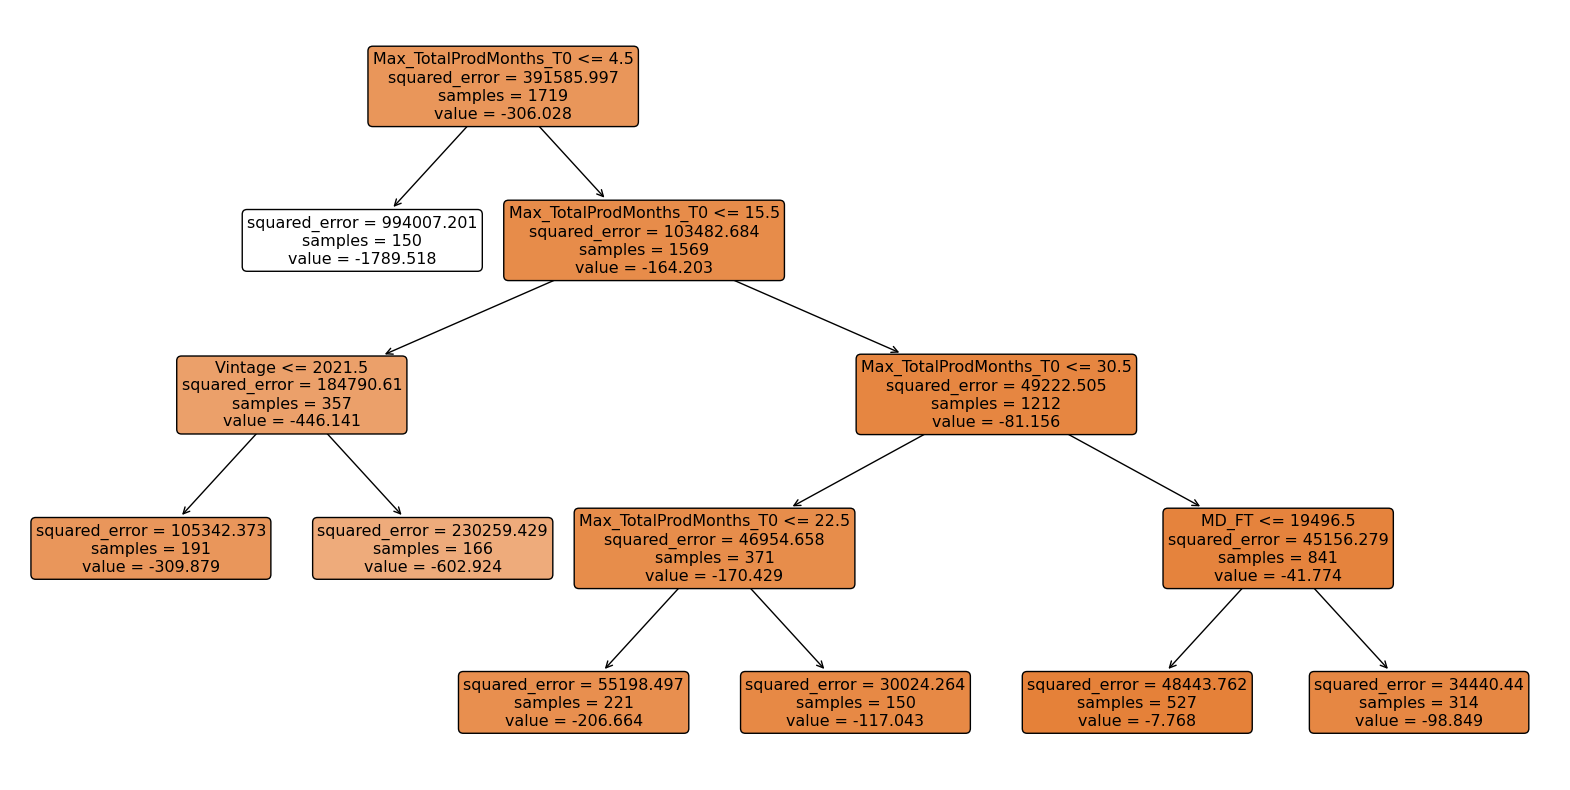

Best parameters: {'max_depth': 4, 'min_samples_leaf': 128, 'min_samples_split': 128}
Mean Absolute Error (MAE): 218.20945994607538
Mean Squared Error (MSE): 193309.12355957838
Root Mean Squared Error (RMSE): 439.669334340682
R-squared (R²): 0.5796429342147749


,Max_TotalProdMonths_T0,LiquidsProd_BBL,GasProd_MCF,LiquidsProd_BBL_cbrt,GasProd_MCF_cbrt,GasProd_MCF_Trend,LiquidsProd_BBL_Trend,ENVSpacingAssumption,PlugbackMeasuredDepth_FT,PlugbackTrueVerticalDepth_FT,AvgFluidPerStage_BBL,AvgProppantPerStage_LBS,Vintage,ENVElevationKB_FT,ENVElevationGL_FT,ElevationKB_FT,ElevationGL_FT,NumberOfStrings,UpperPerf_FT,LowerPerf_FT,PerfInterval_FT,LateralLength_FT,FracStages,AverageStageSpacing_FT,ProppantLoading_LBSPerGAL,ProppantIntensity_LBSPerFT,Proppant_LBS,TotalWaterPumped_GAL,WaterIntensity_GALPerFT,TotalFluidPumped_BBL,FluidIntensity_BBLPerFT,AcidVolume_BBL,Biocide_LBS,Breaker_LBS,Buffer_LBS,ClayControl_LBS,CrossLinker_LBS,FrictionReducer_LBS,GellingAgent_LBS,IronControl_LBS,ScaleInhibitor_LBS,Surfactant_LBS,Diverter_LBS,ChokeSize_64IN,TestRate_BOEPerDAY,TestRate_BOEPerDAYPer1000FT,TestRate_MCFEPerDAY,OilTestRate_BBLPerDAY,OilTestRate_BBLPerDAYPer1000FT,GasTestRate_MCFPerDAY,GasTestRate_MCFPerDAYPer1000FT,WaterTestRate_BBLPerDAY,WaterTestRate_BBLPerDAYPer1000Ft,TestWHLiquids_PCT,CasingPressure_PSI,FlowingTubingPressure_PSI,OilGravity_API,Tortuosity,ToeAngle_DEG,AzimuthFromGridNorth_DEG,Latitude,Longitude,Latitude_BH,Longitude_BH,TVD_FT,MD_FT,Section,TopOfZone_FT,BottomOfZone_FT,SubseaTopDepth_FT,SubseaBaseDepth_FT,Isopach_FT,GammaRay_API,BulkDensity_GPerCC,Resistivity_OHMSM,DensityPorosity_PCT,EffectivePorosity_PCT,ClayVolume_PCT,NonClayVolume_PCT,WaterSaturation_PCT,PhiH_FT,HCPV_PCT,HeightOfHCPV_FT,TotalOrganicCarbon_WTPCT,WellDensityAnyZone,WellDensitySameZone,WellsPerSectionAnyZone,WellsPerSectionSameZone,ImpliedWellSpacingSameZone_FT,AvgHzDistAtDrillTimeSameZone_FT,AvgVtDistAtDrillTimeSameZone_FT,ClosestHzDistAtDrillTimeSameZone_FT,ClosestVtDistAtDrillTimeSameZone_FT,AvgHzDistAtDrillTimeAnyZone_FT,AvgVtDistAtDrillTimeAnyZone_FT,ClosestHzDistAtDrillTimeAnyZone_FT,ClosestVtDistAtDrillTimeAnyZone_FT,ClosestHzDistAtDrillTime100dVZone_FT,ClosestVtDistAtDrillTime100dVZone_FT,AvgHzDistAtDrillTime100dVZone_FT,AvgVtDistAtDrillTime100dVZone_FT,AvgHzDistSameZone_FT,AvgVtDistSameZone_FT,ClosestHzDistSameZone_FT,ClosestVtDistSameZone_FT,AvgHzDistAnyZone_FT,AvgVtDistAnyZone_FT,ClosestHzDistAnyZone_FT,ClosestVtDistAnyZone_FT,ClosestHzDist100dVZone_FT,ClosestVtDist100dVZone_FT,AvgHzDist100dVZone_FT,AvgVtDist100dVZone_FT,ClosestAnyProdMonthDiff,AverageAnyProdMonthDiff,ClosestSameProdMonthDiff,AverageSameProdMonthDiff,Closest100dVProdMonthDiff,Average100dVProdMonthDiff,TestRate_MCFEPerDAYPer1000FT,Avg3DDistSameZone_FT,NearNeighborCountSameZone,Closest3DDistAtDrillTimeAnyZone_FT,Closest3DDistAtDrillTimeSameZone_FT,Avg3DDistAtDrillTimeAnyZone_FT,Avg3DDistAtDrillTimeSameZone_FT,Closest3DDistToParentAtDrillTimeAnyZone_FT,Closest3DDistToParentAtDrillTimeSameZone_FT,Avg3DDistToParentAtDrillTimeAnyZone_FT,Avg3DDistToParentAtDrillTimeSameZone_FT,ClosestHzDistToParentAtDrillTimeAnyZone_FT,ClosestHzDistToParentAtDrillTimeSameZone_FT,AvgHzDistToParentAtDrillTimeAnyZone_FT,AvgHzDistToParentAtDrillTimeSameZone_FT,ClosestVtDistToParentAtDrillTimeAnyZone_FT,ClosestVtDistToParentAtDrillTimeSameZone_FT,AvgVtDistToParentAtDrillTimeAnyZone_FT,AvgVtDistToParentAtDrillTimeSameZone_FT,ParentWellCountAtDrillTimeAnyZone,ParentWellCountAtDrillTimeSameZone,NearNeighborCountAtDrillTimeAnyZone,NearNeighborCountAtDrillTimeSameZone,Closest3DDistAnyZone_FT,Closest3DDistSameZone_FT,Avg3DDistAnyZone_FT,NearNeighborCountAnyZone,Closest3DDistAtDrillTime100dVZone_FT,Avg3DDistAtDrillTime100dVZone_FT,Closest3DDistToParentAtDrillTime100dVZone_FT,Avg3DDistToParentAtDrillTime100dVZone_FT,ClosestHzDistToParentAtDrillTime100dVZone_FT,AvgHzDistToParentAtDrillTime100dVZone_FT,ParentWellCountAtDrillTime100dVZone,NearNeighborCountAtDrillTime100dVZone,Closest3DDist100dVZone_FT,Avg3DDist100dVZone_FT,NearNeighborCount100dVZone,ClosestVtDistToParentAtDrillTime100dVZone_FT,AvgVtDistToParentAtDrillTime100dVZone_FT,ogrid,Freshwater_250,Freshwater_500,Freshwater_750,Freshwater_1000,WellPadDirection_N,WellPadDirection_NA,WellPadDirection_NE,WellPadDirectio

In [144]:
# Split the dataset into features (X) and target (y)
selected_target= 'LiquidsProd_BBL_Trend'
targets = ['LiquidsProd_BBL', 'GasProd_MCF', 'LiquidsProd_BBL_cbrt', 'GasProd_MCF_cbrt', 
                 'GasProd_MCF_Trend', 'LiquidsProd_BBL_Trend']

target_drop = [target for target in targets if target not in selected_target]

#selected_variables
#X = Metadata_Prod_Classify_T.drop(targets, axis=1)
X = Metadata_Prod_Classify_T[selected_variables]
y = Metadata_Prod_Classify_T[selected_target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set up a grid search with the most common parameters for a decision tree regressor
param_grid = {
    'max_depth': [ 4, 5],
    'min_samples_split': [int(0.075 * len(X_train))],
    'min_samples_leaf': [int(0.075 * len(X_train))]
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model using the training data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_tree = grid_search.best_estimator_

# Plot the decision tree with the best parameters
plt.figure(figsize=(20, 10))
plot_tree(best_tree, filled=True, feature_names=X.columns, rounded=True)
plt.show()

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred = best_tree.predict(X_test)

# Calculate and print the KPIs
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

# Apply the best_tree model to get the index of the leaf node for each sample
leaf_nodes = best_tree.apply(Metadata_Prod_Classify_T[selected_variables])

# Add the leaf node indices to your dataset
Metadata_Prod_Classify_T['Leaf_Node'] = leaf_nodes

# Display the updated dataset
Metadata_Prod_Classify_T.head()


The R-square of this approach is not the best of all the tested configurations, but it give us a different dimension of the production that is totally worth it when predicting the SARIMAX. This decision tree help us understanding the variables that we require to classify our wells.

## SARIMAX Prediction

In [148]:
# Creating a subset with only 'API_UWI' and 'Leaf_Node'
leaf_node_data = Metadata_Prod_Classify_T[['Leaf_Node', 'API_UWI']]

# Merging the 'Leaf_Node' information onto 'Prod_Data_3'
Production_Groups = pd.merge(Prod_Data_3, leaf_node_data, on='API_UWI', how='inner')
Production_Groups.head()

,API_UWI,ProducingMonth,TotalProdMonths,ProducingDays,Prod_BOE,Prod_MCFE,LiquidsProd_BBL,GasProd_MCF,WaterProd_BBL,CDProd_BOEPerDAY,CDProd_MCFEPerDAY,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,PDProd_BOEPerDAY,PDProd_MCFEPerDAY,PDLiquids_BBLPerDAY,PDGas_MCFPerDAY,PDWater_BBLPerDAY,Prod_BOE_log,Prod_BOE_sqrt,Prod_BOE_cbrt,Prod_MCFE_log,Prod_MCFE_sqrt,Prod_MCFE_cbrt,LiquidsProd_BBL_log,LiquidsProd_BBL_sqrt,LiquidsProd_BBL_cbrt,GasProd_MCF_log,GasProd_MCF_sqrt,GasProd_MCF_cbrt,WaterProd_BBL_log,WaterProd_BBL_sqrt,WaterProd_BBL_cbrt,CDProd_BOEPerDAY_log,CDProd_BOEPerDAY_sqrt,CDProd_BOEPerDAY_cbrt,CDProd_MCFEPerDAY_log,CDProd_MCFEPerDAY_sqrt,CDProd_MCFEPerDAY_cbrt,CDLiquids_BBLPerDAY_log,CDLiquids_BBLPerDAY_sqrt,CDLiquids_BBLPerDAY_cbrt,CDGas_MCFPerDAY_log,CDGas_MCFPerDAY_sqrt,CDGas_MCFPerDAY_cbrt,CDWater_BBLPerDAY_log,CDWater_BBLPerDAY_sqrt,CDWater_BBLPerDAY_cbrt,PDProd_BOEPerDAY_log,PDProd_BOEPerDAY_sqrt,PDProd_BOEPerDAY_cbrt,PDProd_MCFEPerDAY_log,PDProd_MCFEPerDAY_sqrt,PDProd_MCFEPerDAY_cbrt,PDLiquids_BBLPerDAY_log,PDLiquids_BBLPerDAY_sqrt,PDLiquids_BBLPerDAY_cbrt,PDGas_MCFPerDAY_log,PDGas_MCFPerDAY_sqrt,PDGas_MCFPerDAY_cbrt,PDWater_BBLPerDAY_log,PDWater_BBLPerDAY_sqrt,PDWater_BBLPerDAY_cbrt,Max_TotalProdMonths,T,Max_TotalProdMonths_T0,Leaf_Node
0,30-015-43920,2020-09-01,31,30,4640.0,27841.0,2664.0,11857.0,16911.0,155.0,928.0,89.0,395.0,564.0,155.0,928.0,89.0,395.0,564.0,8.442685,68.117545,16.679102,10.234301,166.856226,30.308302,7.887959,51.613952,13.862602,9.380758,108.889853,22.802980,9.735779,130.042301,25.667866,5.049856,12.449900,5.371685,6.834109,30.463092,9.753998,4.499810,9.433981,4.464745,5.981414,19.874607,7.337234,6.336826,23.748684,8.262149,5.049856,12.449900,5.371685,6.834109,30.463092,9.753998,4.499810,9.433981,4.464745,5.981414,19.874607,7.337234,6.336826,23.748684,8.262149,67,-24,55,11
1,30-015-43920,2020-10-01,32,31,4776.0,28658.0,2797.0,11876.0,17806.0,154.0,924.0,90.0,383.0,574.0,154.0,924.0,90.0,383.0,574.0,8.471568,69.108610,16.840492,10.263223,169.286739,30.601917,7.936660,52.886671,14.089562,9.382359,108.977062,22.815154,9.787347,133.439125,26.112921,5.043425,12.409674,5.360108,6.829794,30.397368,9.739963,4.510860,9.486833,4.481405,5.950643,19.570386,7.262167,6.354370,23.958297,8.310694,5.043425,12.409674,5.360108,6.829794,30.397368,9.739963,4.510860,9.486833,4.481405,5.950643,19.570386,7.262167,6.354370,23.958297,8.310694,67,-23,55,11
2,30-015-43920,2020-11-01,33,30,4532.0,27190.0,2649.0,11296.0,18077.0,151.0,906.0,88.0,377.0,603.0,151.0,906.0,88.0,377.0,603.0,8.419139,67.320131,16.548678,10.210641,164.893905,30.070206,7.882315,51.468437,13.836534,9.332292,106.282642,22.437522,9.802451,134.450734,26.244731,5.023881,12.288206,5.325074,6.810142,30.099834,9.676302,4.488636,9.380832,4.447960,5.934894,19.416488,7.224045,6.403574,24.556058,8.448361,5.023881,12.288206,5.325074,6.810142,30.099834,9.676302,4.488636,9.380832,4.447960,5.934894,19.416488,7.224045,6.403574,24.556058,8.448361,67,-22,55,11
3,30-015-43920,2020-12-01,34,31,4448.0,26685.0,2537.0,11463.0,17506.0,143.0,861.0,82.0,370.0,565.0,143.0,861.0,82.0,370.0,565.0,8.400435,66.693328,16.445797,10.191894,163.355441,29.882877,7.839132,50.368641,13.638716,9.346967,107.065401,22.547554,9.770356,132.310241,25.965437,4.969813,11.958261,5.229322,6.759255,29.342802,9.513370,4.418841,9.055385,4.344481,5.916202,19.235384,7.179054,6.338594,23.769729,8.267029,4.969813,11.958261,5.229322,6.759255,29.342802,9.513370,4.418841,9.055385,4.344481,5.916202,19.235384,7.179054,6.338594,23.769729,8.267029,67,-21,55,11
4,30-015-43920,2021-01-01,35,31,4149.0,24895.0,2459.0,10141.0,14566.0,134.0,803.0,79.0,327.0,470.0,134.0,803.0,79.0,327.0,470.0,8.330864,64.412732,16.068715,10.122462,157.781494,29.199184,7.807917,49.588305,13.497485,9.224440,100.702532,21.645133,9.586514,120.689685,24.421937,4.905275,11.575837,5.117230,6.689599,28.337255,9.294767,4.382027,8.888194,4.290840,5.793014,18.083141,6.889419,6.154858,21.679483,7.774980,4.905275,11.575837,5.117230,6.689599,

In [149]:
# List of columns to exclude from mean calculation
exclude_columns = ['Max_TotalProdMonths', 'Max_TotalProdMonths_T0', 'ProducingMonth', 'API_UWI', 'TotalProdMonths']

# Columns used in groupby should also be excluded
groupby_columns = ['Leaf_Node', 'T']

# Determine the columns for which the mean should be calculated
mean_columns = [col for col in Production_Groups.columns if col not in exclude_columns + groupby_columns]

# Calculate means using a loop and update the dictionary dynamically for aggregation
aggregation_dict = {col: 'mean' for col in mean_columns}

# Include the special case for ProducingMonth
aggregation_dict['ProducingMonth'] = lambda x: x.mode()[0] if not x.mode().empty else None

# Perform the groupby operation with the dynamic aggregation dictionary
Production_Groups_Summary = Production_Groups.groupby(groupby_columns).agg(aggregation_dict).reset_index()

Production_Groups_Summary.head(5)  # Display the top rows of the resulting DataFrame to verify

,Leaf_Node,T,ProducingDays,Prod_BOE,Prod_MCFE,LiquidsProd_BBL,GasProd_MCF,WaterProd_BBL,CDProd_BOEPerDAY,CDProd_MCFEPerDAY,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,PDProd_BOEPerDAY,PDProd_MCFEPerDAY,PDLiquids_BBLPerDAY,PDGas_MCFPerDAY,PDWater_BBLPerDAY,Prod_BOE_log,Prod_BOE_sqrt,Prod_BOE_cbrt,Prod_MCFE_log,Prod_MCFE_sqrt,Prod_MCFE_cbrt,LiquidsProd_BBL_log,LiquidsProd_BBL_sqrt,LiquidsProd_BBL_cbrt,GasProd_MCF_log,GasProd_MCF_sqrt,GasProd_MCF_cbrt,WaterProd_BBL_log,WaterProd_BBL_sqrt,WaterProd_BBL_cbrt,CDProd_BOEPerDAY_log,CDProd_BOEPerDAY_sqrt,CDProd_BOEPerDAY_cbrt,CDProd_MCFEPerDAY_log,CDProd_MCFEPerDAY_sqrt,CDProd_MCFEPerDAY_cbrt,CDLiquids_BBLPerDAY_log,CDLiquids_BBLPerDAY_sqrt,CDLiquids_BBLPerDAY_cbrt,CDGas_MCFPerDAY_log,CDGas_MCFPerDAY_sqrt,CDGas_MCFPerDAY_cbrt,CDWater_BBLPerDAY_log,CDWater_BBLPerDAY_sqrt,CDWater_BBLPerDAY_cbrt,PDProd_BOEPerDAY_log,PDProd_BOEPerDAY_sqrt,PDProd_BOEPerDAY_cbrt,PDProd_MCFEPerDAY_log,PDProd_MCFEPerDAY_sqrt,PDProd_MCFEPerDAY_cbrt,PDLiquids_BBLPerDAY_log,PDLiquids_BBLPerDAY_sqrt,PDLiquids_BBLPerDAY_cbrt,PDGas_MCFPerDAY_log,PDGas_MCFPerDAY_sqrt,PDGas_MCFPerDAY_cbrt,PDWater_BBLPerDAY_log,PDWater_BBLPerDAY_sqrt,PDWater_BBLPerDAY_cbrt,ProducingMonth
0,1,-3,24.342105,33416.640000,200499.604211,23064.568421,62990.463158,58612.851579,1109.104211,6654.783158,765.057895,2093.710526,1948.485263,1195.308421,7171.700000,829.894737,2215.407368,2350.763158,9.646727,161.284764,28.361365,11.438083,395.065166,51.535982,9.256077,133.106444,24.918890,10.189617,221.548953,34.973689,9.913314,209.276832,33.307341,6.255253,29.397481,9.118212,8.037404,72.012736,16.570368,5.867628,24.255696,8.010134,6.829327,40.395004,11.233278,6.542803,38.172452,10.714260,6.596459,31.493983,9.694611,8.384606,77.141361,17.615779,6.207331,26.059766,8.530952,7.155694,42.903881,11.890611,6.891062,43.809727,11.882064,2022-06-01
1,1,-2,23.423423,40223.932613,241343.572613,27236.388829,75199.293694,78229.579099,1303.696577,7822.539820,883.280000,2431.846847,2537.014775,1674.652973,10048.237838,1130.522523,3159.852252,3392.558559,10.179571,186.845731,31.934865,11.971117,457.676672,58.029532,9.727366,153.186933,27.907259,10.813661,255.310780,39.327965,10.230451,253.480884,38.255740,6.756972,33.621061,10.177639,8.540988,82.354240,18.493180,6.317268,27.566518,8.892604,7.384130,45.898214,12.526343,6.921571,45.619209,12.181875,7.125821,39.007427,11.316858,8.910676,95.545900,20.562754,6.683616,31.904341,9.872161,7.751595,53.439830,13.950778,7.248748,53.443425,13.590787,2022-07-01
2,1,-1,28.316901,48284.422254,289706.647042,33552.656338,88865.177465,93133.319718,1567.041408,9402.438592,1089.047042,2892.830986,3030.155775,1712.541972,10275.639437,1187.802817,3128.650704,3355.521127,10.541779,209.457956,34.780843,12.333495,513.064980,63.200964,10.174502,174.405531,30.776433,11.067000,280.686631,42.087278,11.182949,292.784028,43.521321,7.113054,37.714774,11.089034,8.903586,92.383542,20.150361,6.746254,31.403946,9.812373,7.639709,50.597921,13.427343,7.779355,52.776664,13.885445,7.272495,39.894594,11.559227,9.063546,97.724004,21.004945,6.901878,33.194001,10.222636,7.796340,53.230302,13.949670,7.945585,56.153724,14.526304,2022-08-01
3,1,0,29.048193,45527.036145,273161.849398,30871.709398,86087.897590,80915.225060,1510.789157,9064.560241,1025.105542,2860.150602,2685.737590,1570.811807,9424.739759,1065.415663,2965.881205,2839.018072,10.460736,204.102503,34.187573,12.241662,499.946448,62.122892,10.060762,167.736607,29.972683,11.057694,278.858321,42.017000,11.121030,273.965615,41.753033,7.078695,37.196436,10.990434,8.858454,91.110833,19.970657,6.680088,30.577989,9.637310,7.676624,50.846364,13.511823,7.718047,49.935135,13.423667,7.124420,37.969736,11.147041,8.904275,93.005349,20.255307,6.724984,31.205680,9.772773,7.720550,51.842690,13.694344,7.765517,51.239022,13.650282,2022-09-01
4,1,1,27.723502,40741.340645,244447.782304,27604.763871,77924.247926,74942.752258,1318.371060,7910.249401,893.710968,2522.953917,2427.778986,1460.747834,8764.591705,996.82

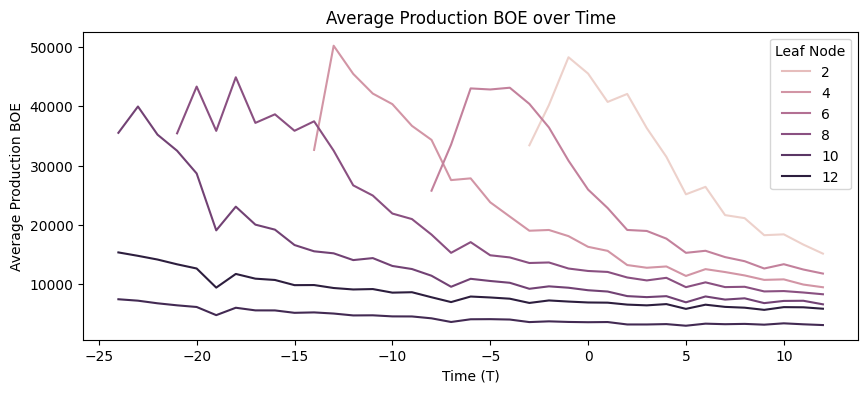

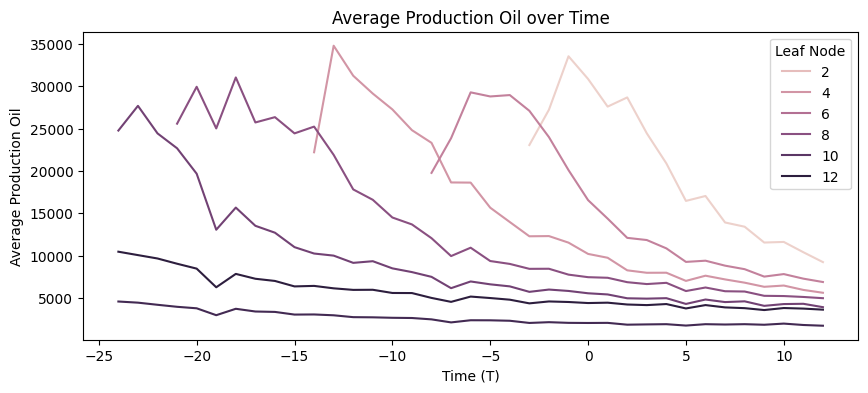

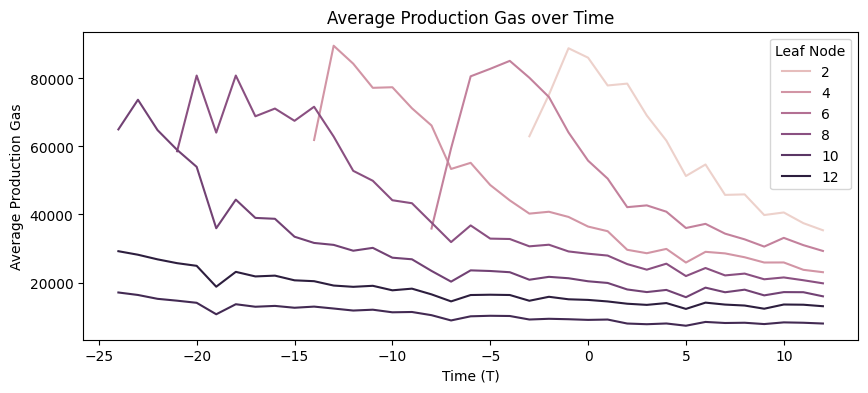

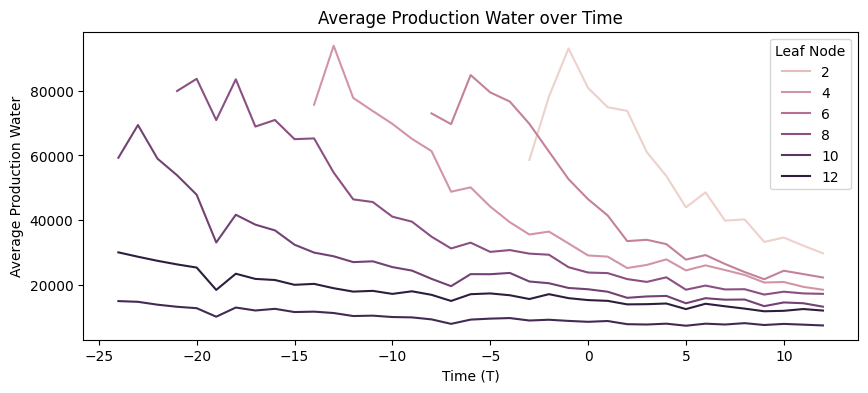

In [150]:
# Set the color palette
sns.set_palette("viridis", n_colors=Production_Groups_Summary['Leaf_Node'].nunique())

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot Avg_Prod_BOE
plt.figure(figsize=(10, 4))
sns.lineplot(data=Production_Groups_Summary, x='T', y='Prod_BOE', hue='Leaf_Node')
plt.title('Average Production BOE over Time')
plt.xlabel('Time (T)')
plt.ylabel('Average Production BOE')
plt.legend(title='Leaf Node')
plt.show()

# Plot Avg_Prod_Oil
plt.figure(figsize=(10, 4))
sns.lineplot(data=Production_Groups_Summary, x='T', y='LiquidsProd_BBL', hue='Leaf_Node')
plt.title('Average Production Oil over Time')
plt.xlabel('Time (T)')
plt.ylabel('Average Production Oil')
plt.legend(title='Leaf Node')
plt.show()

# Plot Avg_Prod_Gas
plt.figure(figsize=(10, 4))
sns.lineplot(data=Production_Groups_Summary, x='T', y='GasProd_MCF', hue='Leaf_Node')
plt.title('Average Production Gas over Time')
plt.xlabel('Time (T)')
plt.ylabel('Average Production Gas')
plt.legend(title='Leaf Node')
plt.show()

# Plot Avg_Prod_Wtr
plt.figure(figsize=(10, 4))
sns.lineplot(data=Production_Groups_Summary, x='T', y='WaterProd_BBL', hue='Leaf_Node')
plt.title('Average Production Water over Time')
plt.xlabel('Time (T)')
plt.ylabel('Average Production Water')
plt.legend(title='Leaf Node')
plt.show()


BEAUTIFUL CURVES!!! We can see that the nodes of the decision tree split very good our wells according to the production performance in each of the variables of our interest. 

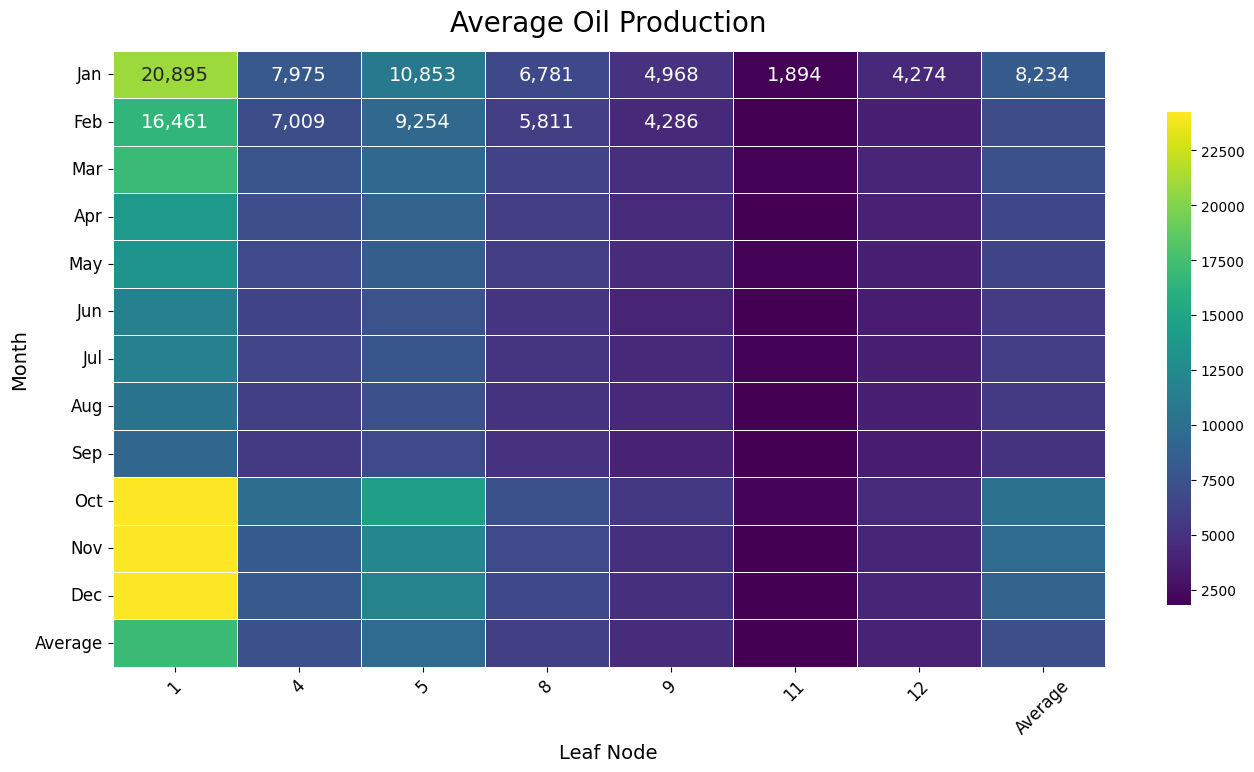

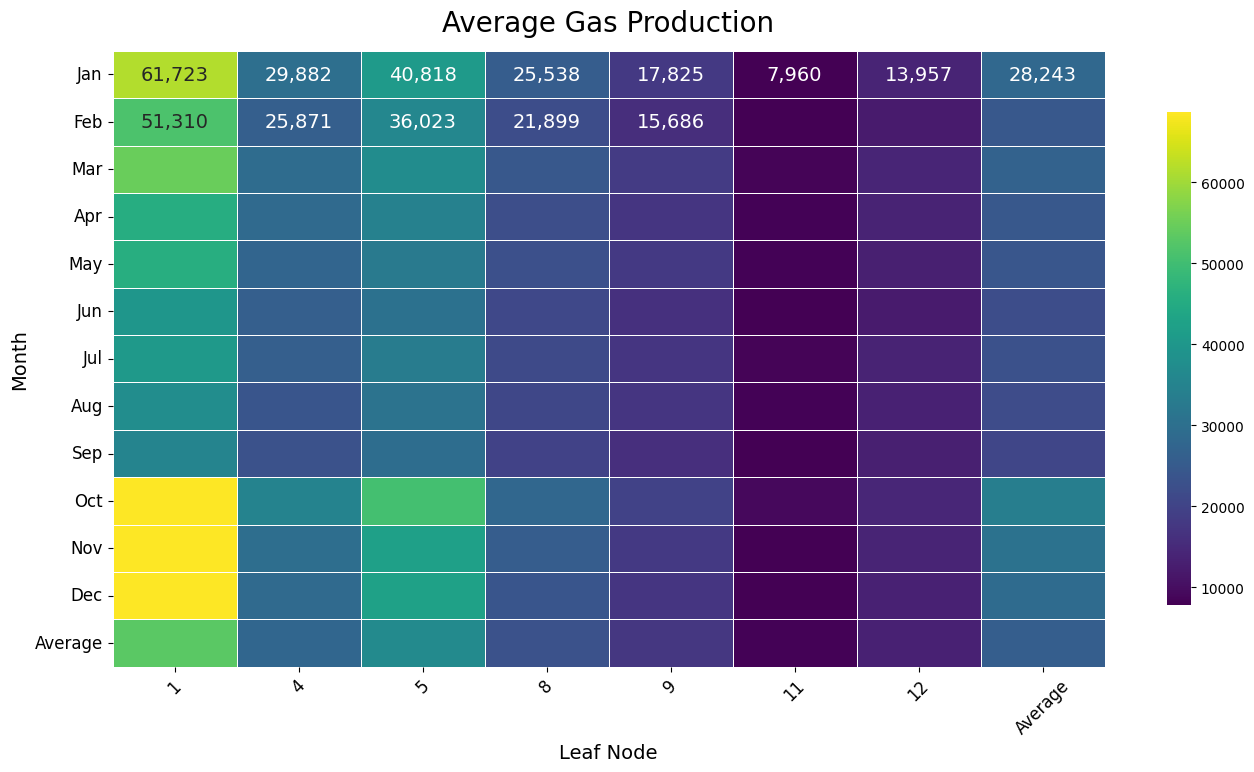

In [151]:
# Copying the DataFrame
production_SARIMAX = Production_Groups_Summary.copy()

# Extracting month and year information
production_SARIMAX['month'] = production_SARIMAX['ProducingMonth'].dt.month
production_SARIMAX['year'] = production_SARIMAX['ProducingMonth'].dt.year

df_post = production_SARIMAX[production_SARIMAX['T'] > 0]

# Look at the average values of LiquidsProd_BBL per month and year
liquids_avg_df = pd.pivot_table(df_post,
                                index=["month"],
                                columns=["Leaf_Node"],
                                values="LiquidsProd_BBL",
                                aggfunc="mean",  # Calculate the mean
                                margins=True,
                                margins_name="Average")

# Look at the average values of GasProd_MCF per month and year
gas_avg_df = pd.pivot_table(df_post,
                            index=["month"],
                            columns=["Leaf_Node"],
                            values="GasProd_MCF",
                            aggfunc="mean",  # Calculate the mean
                            margins=True,
                            margins_name="Average")

# Assign month names as indices
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(liquids_avg_df.index)]]
liquids_avg_df = liquids_avg_df.set_index(named_index)
gas_avg_df = gas_avg_df.set_index(named_index)

def plot_heatmap(df, title):
    plt.figure(figsize=(16, 8))  # Increased figure size
    ax = sns.heatmap(df,
                     cmap='viridis',
                     robust=True,
                     fmt=',.0f',
                     annot=True,
                     linewidths=.5,
                     annot_kws={'size':14},  # Increased annotation font size
                     cbar_kws={'shrink':.8})
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)  # Increased y-tick font size
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)  # Increased x-tick font size and rotated for better visibility
    plt.title(title, fontdict={'fontsize':20}, pad=14)  # Increased title font size
    plt.xlabel('Leaf Node', fontsize=14)  # Increased x-label font size
    plt.ylabel('Month', fontsize=14)  # Increased y-label font size

plot_heatmap(liquids_avg_df, 'Average Oil Production')
plt.show()

plot_heatmap(gas_avg_df, 'Average Gas Production')
plt.show()


In [152]:
Leaf_Nodes=production_SARIMAX['Leaf_Node'].unique()
Leaf_Nodes

array([ 1,  4,  5,  8,  9, 11, 12], dtype=int64)

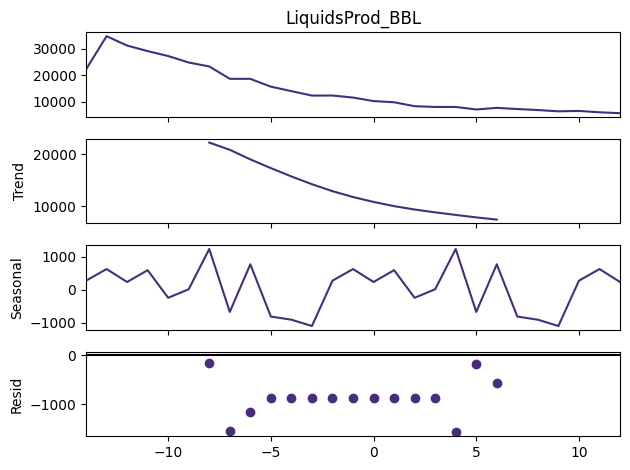

In [153]:
# Ensure the dataset is sorted based on 'T' column and set 'T' as the index
production_SARIMAX_sorted = production_SARIMAX.sort_values(by='T')
production_SARIMAX_sorted.set_index('T', inplace=True)

#Filter Node and Variables

node=4
period=12

production_SARIMAX_sorted = production_SARIMAX_sorted[production_SARIMAX_sorted['Leaf_Node'] == node]

#Comments on our tests, showing the AIC obtained in each segment

#LiquidsProd_BBL

#node=1 Not possible, New Wells
#4: (1, 0, 1) (0, 0, 0, 12) 248.14
#5: (1, 0, 1) (1, 0, 1, 3) 161.18   
#8: (0, 0, 0) (1, 0, 0, 12) 434.58
#9: (2, 2, 1) (1, 0, 1, 12) 348.19
#11: (2, 0, 1) (2, 0, 1, 12) 303.36
#12: (1, 0, 1) (1, 0, 0, 12) 341.88


#GasProd_MCF

#node=1 Not possible, New Wells
#4: (1, 1, 1) (1, 0, 1, 12) 266.29
#5: (1, 0, 1) (0, 0, 0, 3) 188.47    
#8: (1, 0, 1) (0, 0, 0, 12) 409.92
#9: (1, 1, 1) (0, 0, 0, 12) 391.37
#11: (1, 0, 1) (2, 0, 0, 3) 408.90   
#12: (2, 0, 1) (0, 0, 0, 12) 379.63


target_variable = 'LiquidsProd_BBL'
x_features = ['GasProd_MCF', 'WaterProd_BBL']

#target_variable = 'GasProd_MCF'
#x_features = ['LiquidsProd_BBL', 'WaterProd_BBL']

lower = 'lower' + ' ' + target_variable
upper = 'upper' + ' ' + target_variable

# Assuming 'Avg_Prod_Oil' as the time series to decompose
production_SARIMAX_t = production_SARIMAX_sorted[target_variable]

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(production_SARIMAX_t, model='additive', period=period)

# Extract the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
decomposition_fig = decomposition.plot()
plt.show()


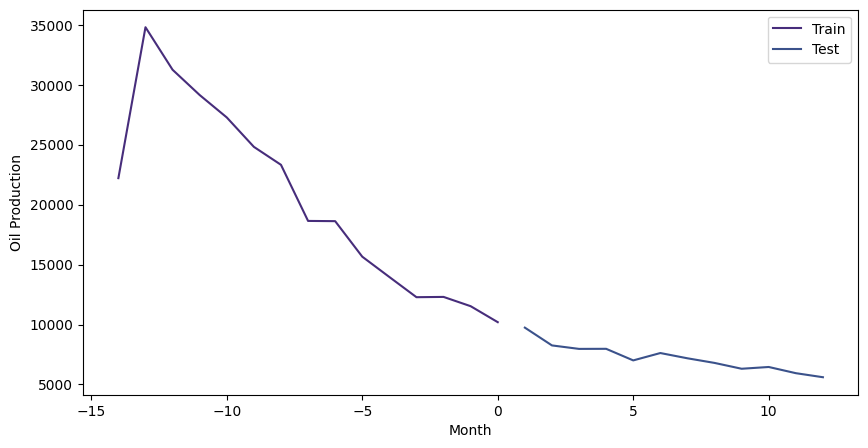

In [154]:
# Split into training and testing - can't do random split as data is in time order
production_train = production_SARIMAX_t.loc[:'0']
production_test = production_SARIMAX_t.loc['1':]

ax = production_train.plot(figsize=(10, 5))
production_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Month')
plt.ylabel('Oil Production')
plt.show()

In [155]:
exog_data = production_SARIMAX_sorted[x_features].loc[:'0']
exog_future = production_SARIMAX_sorted[x_features].loc['1':]

from sklearn.preprocessing import StandardScaler

# Initialize scaler
sc = StandardScaler()

# Fit the scaler
exog_data = sc.fit_transform(exog_data)

# Transform the data using the scaler
exog_future = sc.transform(exog_future)

In [156]:
import itertools
import math
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(1, 3)  # Autoregressive order
d_values = range(0, 3)  # Differencing order
q_values = range(1, 2)  # Moving average order
P_values = range(0, 3)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 3)  # Seasonal moving average order
m_values = [12]         # Seasonal period (example value)

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values))

# Initialize AIC with a large value
best_aic = float("inf")
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = SARIMAX(production_train,
                        order=order,
                        seasonal_order=seasonal_order,
                        exog=exog_data)
        
        result = model.fit(disp=False)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not (np.any(np.isnan(result.zvalues)) or np.any(np.isinf(result.zvalues)) or np.any(result.pvalues > 0.1)):
            if aic < best_aic:
                best_aic = aic
                best_params = params
                print(order, seasonal_order, aic)

    except Exception as e:
        print(f"Error with parameters {params}: {e}")
        continue

# Check if best_params is None
if best_params is None:
    print("No suitable model found. Using default parameters.")
    best_params = (1, 1, 1, 0, 0, 1, 12)  # Example default parameters

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

model = SARIMAX(production_train,
                order=best_params[:3],
                seasonal_order=best_params[3:],
                exog=exog_data)
result = model.fit(disp=False)

# Show the summary
result.summary()

(1, 0, 1) (0, 0, 0, 12) 248.14117489959298
Best Parameters: (1, 0, 1, 0, 0, 0, 12)
Best AIC: 248.14117489959298


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        LiquidsProd_BBL   No. Observations:                   15
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -119.071
Date:                Wed, 21 Feb 2024   AIC                            248.141
Time:                        23:47:28   BIC                            251.681
Sample:                             0   HQIC                           248.103
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6395.2207   1.48e-05   4.32e+08      0.000    6395.221    6395.221
x2          1220.9567   3.18e-06   3.84e+08      0.000    1220.957    1220.957
ar.L1          1.0000   1.54e-06   6.48e+05      0.000       1.000       1.000
ma.L1         -0.9888      0.185     -5.355      0.000      -1.351      -0.627
sigma2      2.355e+05   1.65e-07   1.43e+12      0.000    2.36e+05    2.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.72   Prob(JB):                         0.89
Heteroskedasticity (H):               0.03   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+28. Standard errors may be unstable.
"""

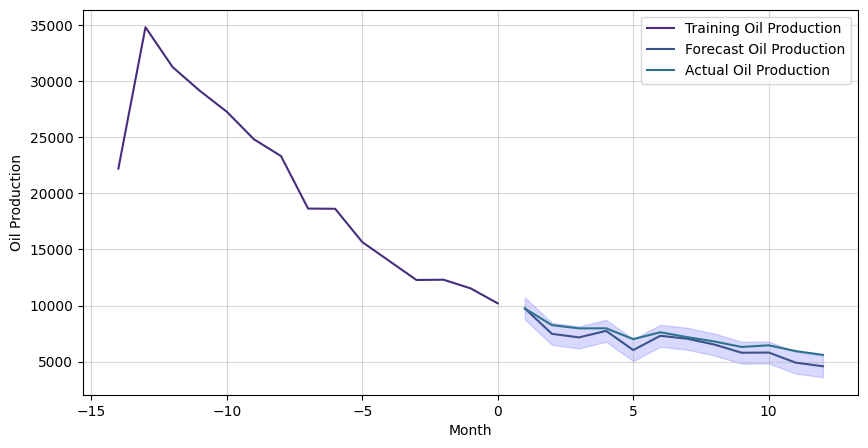

In [157]:
# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=12, exog=exog_future)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

forecast_index = range(1, 13)  # 12 steps ahead starting from 0
forecast_values.index = forecast_index
confidence_intervals.index = forecast_index

# Plot forecast with training data
ax = production_train.plot(figsize=(10,5))
forecast_values.plot()
production_test.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals[lower], 
                 confidence_intervals[upper], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training Oil Production', 
            'Forecast Oil Production', 
            'Actual Oil Production'], 
           loc='upper right')
plt.xlabel('Month')
plt.ylabel('Oil Production')
plt.grid(alpha=0.5)
plt.show()

## Results

In this part of the code, the user is asked for attributes of the wells and he will receive the predicted curves of Oil and Gas. 

In [162]:
import pyinputplus as pyip

def determine_node(max_total_months, vintage, mdft):
    # Adjust the logic based on the provided decision tree structure
    if max_total_months <= 4.5:
        return 1  # Node for max_total_months <= 4.5
    else:  # max_total_months > 4.5
        if max_total_months <= 15.5:
            if vintage <= 2021.5:
                return 4  # Node for max_total_months <= 15.5 and vintage <= 2021.5
            else:
                return 5  # Node for max_total_months <= 15.5 and vintage > 2021.5
        elif max_total_months <= 30.5:
            if max_total_months <= 22.5:
                return 8  # Node for max_total_months <= 22.5
            else:
                return 9  # Node for max_total_months between 22.5 and 30.5
        else:  # max_total_months > 30.5
            if mdft <= 19496.5:
                return 11  # Node for mdft <= 19496.5
            else:
                return 12  # Node for mdft > 19496.5

def get_user_input():
    max_total_months = pyip.inputInt(prompt="Enter the number of months the well has been operating: ", min=1)
    vintage = pyip.inputInt(prompt="Enter the Vintage (First Year of Operation): ", min=1900, max=2023)
    mdft = pyip.inputFloat(prompt="Enter the MDFT (Depth of the Well in feet): ", min=0)
    
    # Determine the node based on input
    node = determine_node(max_total_months, vintage, mdft)
    print(f"Received: Months - {max_total_months}, Vintage - {vintage}, Depth - {mdft}")
    print(f"The well belongs to node: {node}")
    
    return node

node=get_user_input()

Enter the number of months the well has been operating: 13
Enter the Vintage (First Year of Operation): 2020
Enter the MDFT (Depth of the Well in feet): 3567
Received: Months - 13, Vintage - 2020, Depth - 3567.0
The well belongs to node: 4


In [163]:
# Configuration dictionaries for each product type

#Showing the AIC obtained for each of our curves
# Configuration dictionaries for each product type
liquids_config = {
    1: None,
    4: ((1, 0, 1), (0, 0, 0, 12), 248.14),
    5: ((1, 0, 1), (1, 0, 1, 3), 161.18),
    8: ((0, 0, 0), (1, 0, 0, 12), 434.58),
    9: ((2, 2, 1), (1, 0, 1, 12), 348.19),
    11: ((2, 0, 1), (2, 0, 1, 12), 303.36),
    12: ((1, 0, 1), (1, 0, 0, 12), 341.88),
}

gas_config = {
    1: None,
    4: ((1, 1, 1), (1, 0, 1, 12), 266.29),
    5: ((1, 0, 1), (0, 0, 0, 3), 188.47),
    8: ((1, 0, 1), (0, 0, 0, 12), 409.92),
    9: ((1, 1, 1), (0, 0, 0, 12), 391.37),
    11: ((1, 0, 1), (2, 0, 0, 3), 408.90),
    12: ((2, 0, 1), (0, 0, 0, 12), 379.63),
}

def get_configurations(node):
    liquids = liquids_config.get(node, "Unknown node")
    gas = gas_config.get(node, "Unknown node")
    return liquids, gas

# Example usage:
liquids_conf, gas_conf = get_configurations(node)
print(f"The configuration for node {node} for 'LiquidsProd_BBL' is: {liquids_conf}")
print(f"The configuration for node {node} for 'GasProd_MCF' is: {gas_conf}")


The configuration for node 4 for 'LiquidsProd_BBL' is: ((1, 0, 1), (0, 0, 0, 12), 248.14)
The configuration for node 4 for 'GasProd_MCF' is: ((1, 1, 1), (1, 0, 1, 12), 266.29)


Note: Our model is restricted for wells with existent performance. The new wells can use the production curve obtained with node 1, but a forecast model was not built for that segment; instead, we could use the real curve of the past assuming a similar future. 

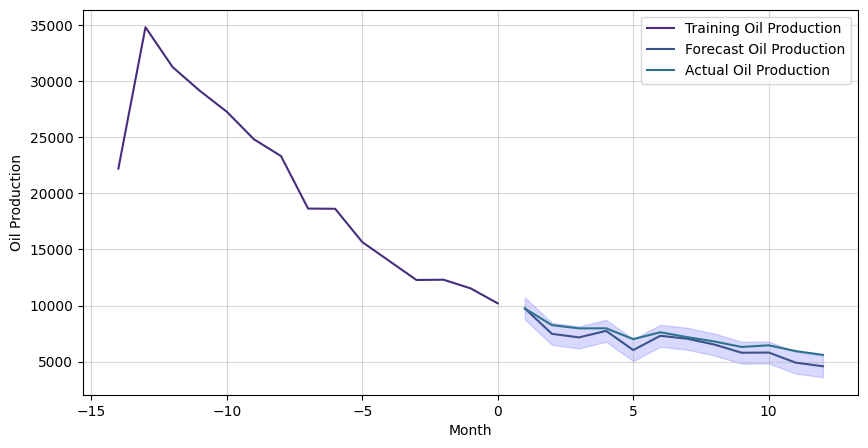

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        LiquidsProd_BBL   No. Observations:                   15
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -119.071
Date:                Wed, 21 Feb 2024   AIC                            248.141
Time:                        23:52:27   BIC                            251.681
Sample:                             0   HQIC                           248.103
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6395.2207   1.48e-05   4.32e+08      0.000    6395.221    6395.221
x2          1220.9567   3.18e-06   3.84e+08      0.000    1220.957    1220.957
ar.L1          1.0000   1.54e-06   6.48e+05      0.000       1.000       1.000
ma.L1         -0.9888      0.185     -5.355      0.000      -1.351      -0.627
sigma2      2.355e+05   1.65e-07   1.43e+12      0.000    2.36e+05    2.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.72   Prob(JB):                         0.89
Heteroskedasticity (H):               0.03   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+28. Standard errors may be unstable.
"""

In [164]:
# Ensure the dataset is sorted based on 'T' column and set 'T' as the index
production_SARIMAX_sorted = production_SARIMAX.sort_values(by='T')
production_SARIMAX_sorted.set_index('T', inplace=True)

production_SARIMAX_sorted = production_SARIMAX_sorted[production_SARIMAX_sorted['Leaf_Node'] == node]

#Create a cycle here 

# Extract SARIMAX parameters for LiquidsProd_BBL model
target_variable = 'LiquidsProd_BBL'
x_features = ['GasProd_MCF', 'WaterProd_BBL']
liquids_p, liquids_d, liquids_q = liquids_conf[0]
liquids_P, liquids_D, liquids_Q, liquids_m = liquids_conf[1]

# Extract SARIMAX parameters for GasProd_MCF model
#target_variable = 'GasProd_MCF'
#x_features = ['LiquidsProd_BBL', 'WaterProd_BBL']
gas_p, gas_d, gas_q = gas_conf[0]
gas_P, gas_D, gas_Q, gas_m = gas_conf[1]

lower = 'lower' + ' ' + target_variable
upper = 'upper' + ' ' + target_variable

# Assuming 'Avg_Prod_Oil' as the time series to decompose
production_SARIMAX_t = production_SARIMAX_sorted[target_variable]

production_train = production_SARIMAX_t.loc[:'0']
production_test = production_SARIMAX_t.loc['1':]

exog_data = production_SARIMAX_sorted[x_features].loc[:'0']
exog_future = production_SARIMAX_sorted[x_features].loc['1':]

from sklearn.preprocessing import StandardScaler

# Initialize scaler
sc = StandardScaler()

# Fit the scaler
exog_data = sc.fit_transform(exog_data)

# Transform the data using the scaler
exog_future = sc.transform(exog_future)

warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')

model = SARIMAX(production_train,
                order=(liquids_p, liquids_d, liquids_q),
                seasonal_order=(liquids_P, liquids_D, liquids_Q, liquids_m),
                exog=exog_data)
result = model.fit(disp=False)
aic = result.aic

# Ensure the convergence of the model
if not (np.any(np.isnan(result.zvalues)) or np.any(np.isinf(result.zvalues)) or np.any(result.pvalues > 0.1)):
    if aic < best_aic:
        best_aic = aic
        best_params = params
        print(order, seasonal_order, aic)

model = SARIMAX(production_train,
                order=best_params[:3],
                seasonal_order=best_params[3:],
                exog=exog_data)
result = model.fit(disp=False)

# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=12, exog=exog_future)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

forecast_index = range(1, 13)  # 12 steps ahead starting from 0
forecast_values.index = forecast_index
confidence_intervals.index = forecast_index

# Plot forecast with training data
ax = production_train.plot(figsize=(10,5))
forecast_values.plot()
production_test.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals[lower], 
                 confidence_intervals[upper], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training Oil Production', 
            'Forecast Oil Production', 
            'Actual Oil Production'], 
           loc='upper right')
plt.xlabel('Month')
plt.ylabel('Oil Production')
plt.grid(alpha=0.5)
plt.show()

# Show the summary
result.summary()


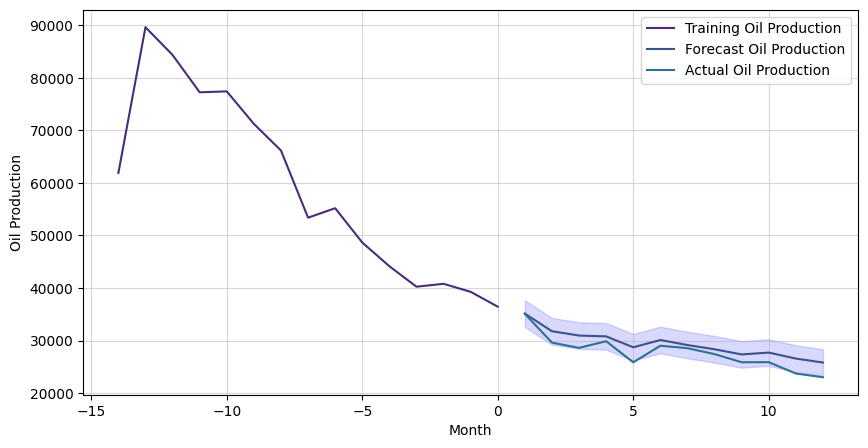

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            GasProd_MCF   No. Observations:                   15
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -133.460
Date:                Wed, 21 Feb 2024   AIC                            276.920
Time:                        23:52:33   BIC                            280.460
Sample:                             0   HQIC                           276.882
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.898e+04   9.08e-07   2.09e+10      0.000     1.9e+04     1.9e+04
x2         -1935.7329   3.53e-05  -5.49e+07      0.000   -1935.733   -1935.733
ar.L1          1.0000   5.82e-07   1.72e+06      0.000       1.000       1.000
ma.L1         -0.9893      0.278     -3.554      0.000      -1.535      -0.444
sigma2      1.578e+06   7.51e-08    2.1e+13      0.000    1.58e+06    1.58e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.70   Prob(JB):                         0.82
Heteroskedasticity (H):               0.04   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.85e+28. Standard errors may be unstable.
"""

In [165]:
# Ensure the dataset is sorted based on 'T' column and set 'T' as the index
production_SARIMAX_sorted = production_SARIMAX.sort_values(by='T')
production_SARIMAX_sorted.set_index('T', inplace=True)

production_SARIMAX_sorted = production_SARIMAX_sorted[production_SARIMAX_sorted['Leaf_Node'] == node]

#Create a cycle here 

# Extract SARIMAX parameters for LiquidsProd_BBL model
#target_variable = 'LiquidsProd_BBL'
#x_features = ['GasProd_MCF', 'WaterProd_BBL']
liquids_p, liquids_d, liquids_q = liquids_conf[0]
liquids_P, liquids_D, liquids_Q, liquids_m = liquids_conf[1]

# Extract SARIMAX parameters for GasProd_MCF model
target_variable = 'GasProd_MCF'
x_features = ['LiquidsProd_BBL', 'WaterProd_BBL']
gas_p, gas_d, gas_q = gas_conf[0]
gas_P, gas_D, gas_Q, gas_m = gas_conf[1]

lower = 'lower' + ' ' + target_variable
upper = 'upper' + ' ' + target_variable

# Assuming 'Avg_Prod_Oil' as the time series to decompose
production_SARIMAX_t = production_SARIMAX_sorted[target_variable]

production_train = production_SARIMAX_t.loc[:'0']
production_test = production_SARIMAX_t.loc['1':]

exog_data = production_SARIMAX_sorted[x_features].loc[:'0']
exog_future = production_SARIMAX_sorted[x_features].loc['1':]

from sklearn.preprocessing import StandardScaler

# Initialize scaler
sc = StandardScaler()

# Fit the scaler
exog_data = sc.fit_transform(exog_data)

# Transform the data using the scaler
exog_future = sc.transform(exog_future)

warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')

model = SARIMAX(production_train,
                order=(gas_p, gas_d, gas_q),
                seasonal_order=(gas_P, gas_D, gas_Q, gas_m),
                exog=exog_data)
result = model.fit(disp=False)
aic = result.aic

# Ensure the convergence of the model
if not (np.any(np.isnan(result.zvalues)) or np.any(np.isinf(result.zvalues)) or np.any(result.pvalues > 0.1)):
    if aic < best_aic:
        best_aic = aic
        best_params = params
        print(order, seasonal_order, aic)

model = SARIMAX(production_train,
                order=best_params[:3],
                seasonal_order=best_params[3:],
                exog=exog_data)
result = model.fit(disp=False)

# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=12, exog=exog_future)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

forecast_index = range(1, 13)  # 12 steps ahead starting from 0
forecast_values.index = forecast_index
confidence_intervals.index = forecast_index

# Plot forecast with training data
ax = production_train.plot(figsize=(10,5))
forecast_values.plot()
production_test.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals[lower], 
                 confidence_intervals[upper], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training Oil Production', 
            'Forecast Oil Production', 
            'Actual Oil Production'], 
           loc='upper right')
plt.xlabel('Month')
plt.ylabel('Oil Production')
plt.grid(alpha=0.5)
plt.show()

# Show the summary
result.summary()

## Conclusion

Our analysis successfully developed a machine learning model that surpasses traditional forecasting methods in the oil and gas extraction industry. By categorizing wells based on key attributes and applying time series analysis, we achieved strong KPIs and stable segment readings, enhancing investment prioritization and earnings potential. However, the model's accuracy is subject to certain limitations, such as data representativeness, production history requirements, and geographic specificity. Addressing these limitations will further refine the model and ensure the reliability of our data-driven decisions, ultimately boosting our client's profitability in a competitive market.